In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import gzip
import os
import gc
import multiprocessing
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning,message='Mean of empty slice')

import seaborn as sns
import scipy

In [2]:
# import definitions_2018 as bd
year = 2019
workstation=162

if workstation==162:
    %cd '/home/jdavidson/bees_sharedcodes/Bees_sharedcodes/'
elif workstation==163:
    %cd '/sharedcodes/bees/code/'
else:
    %cd '/users/jacob/Seafile/Bees_sharedcodes/'

import definitions_2019 as bd
if workstation==162:
    resultsdir = '/home/jdavidson/bees_data/beeresults2019/'
    comb_contents_dir = '/home/jdavidson/bees_data/comb-contents-images2019/'    
elif workstation==163:
    resultsdir = '/data/beeresults2019/'
    comb_contents_dir = '/data/comb-contents-images2019/'
else: # local, JD laptop
    resultsdir = '/users/jacob/Seafile/beeresults2019/'
    comb_contents_dir = '/users/jacob/Seafile/comb-contents-images2019/'
zfilln = 3 # for file names    
    
import displayfunctions as bp  # 'bee plots'
import datafunctions as dfunc
# import data_and_embedding
dfunc.init(bd) 
bp.init(bd)
# import data_and_embedding2019 as de  # data_and_embedding2019.py
bd.year

/home/jdavidson/bees_sharedcodes/Bees_sharedcodes


/home/jdavidson/bees_sharedcodes/Bees_sharedcodes/definitions_2019.py:29: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  cohort_birthdates = np.array([pd.Timestamp(np.array(cohort_data['DOB'][cohort_data['cohort']==c])[0],freq='D') for c in cohort_colornames])


2019

# Load data

In [3]:
recalc=False

In [4]:
numtimedivs = 288  # each hour, or 5 min. For interactions, dont do 1 minute, its too much - use 5 min 

if numtimedivs==24:
    prefix = 'dayhour'
elif numtimedivs==288:
    prefix = 'day5min'
elif numtimedivs==1440:
    prefix = 'day1min'

savefile = resultsdir+'Drones-df-'+prefix+'.pklz'
    
daystoload = np.arange(1,25)
numdays = len(daystoload)

    
if recalc:
    obs_threshold=5
    exitdistthreshold=2500


    # read in multiple days, and get in-out estimates for each
    # filename = resultsdir+'df_'+prefix+'_'+str(daynum).zfill(zfilln)+'.pklz'
    # [dfday] = pickle.load(gzip.open(filename,'rb'))
    for i,daynum in enumerate(daystoload):
        filename = resultsdir+'df_'+prefix+'_'+str(daynum).zfill(zfilln)+'.pklz'
        if i==0:
            [df] = pickle.load(gzip.open(filename,'rb'))
        else:
            df = pd.concat((df,pickle.load(gzip.open(filename,'rb'))[0]))
            


    # now, I updated 
    df['Out of hive'] = np.nan
    df.sort_values(by=['Bee unique ID','Day number','timedivision'],inplace=True)
    df.reset_index(drop=True,inplace=True)  # do this, so that can keep everything in a single dataframe by index

    if numtimedivs==24:
        df['Out of hive'] = 1
    else:
        for daynum in daystoload:
            dfday = df[df['Day number']==daynum]
            day_uids, day_ages, all_inhive, bee_obs, bee_exitdist = dfunc.get_inout_estimates(
                dfday, obs_threshold=obs_threshold, exitdistthreshold=exitdistthreshold,numtimedivs=numtimedivs)
            # set it back in the other dataframe
            df.loc[dfday.index,'Out of hive']=1-all_inhive.flatten()  # this does the same this as the "list extend" that Louisa used

    # see where the measurement period is
    daynum = 10
    measperiods = []
    showplots=False
    for daynum in daystoload:
        dfday = df[df['Day number']==daynum].copy()
        td = dfday['timedivision'].values
        test = dfday['Num. observations'].values
        overtime = []
        nanrange = []
        for i in range(numtimedivs):
            sel = (td==i)
            vals = test[sel]
            overtime.append(vals)
            if np.all(np.isnan(vals)):
    #             print(i)
                nanrange.append(i)
        if showplots|(daynum==daystoload[0]):
            f,ax=plt.subplots(1,1)
            f.set_size_inches(25,2)

        ax.plot([np.nanmean(x) for x in overtime],marker='.')        
        if len(nanrange)>0:
            start, end = np.min(nanrange)-1, np.max(nanrange)+1
            ax.axvline(start,c='r')
            ax.axvline(end,c='r')
            measperiods.append([start,end])
        else:
            measperiods.append([np.nan,np.nan])
        ax.set_title('daynum: '+str(daynum),fontsize=18)
        plt.show() if showplots else None
    measperiods = np.array(measperiods)

    i=0
    daynum=daystoload[i]
    fornanfill = df.columns.drop(['Age','Bee unique ID','Cohort ID','timedivision','Day number'])

    for i,daynum in enumerate(daystoload):
        print(daynum)
        if np.logical_not(np.all(np.isnan(measperiods[i]))):
            start,end=measperiods[i]
            df.loc[(df['Day number']==daynum)&(df['timedivision']>=start)&(df['timedivision']<=end),fornanfill] = np.nan
            
    # convert units
    df['Num. observations'] = df['Num. observations'] /3/60/5  # fraction of 5 min period fully tracked
    qs = ['Median speed', 'Speed 90th quantile', 'Dispersion (avg)','Exit distance (median)', 'Dispersion-minute avg.'] # cm
    for q in qs:
        df[q] = df[q]/bd.pixels_per_cm
    
    pickle.dump([df,measperiods],gzip.open(savefile,'wb'))
else:
    [df,measperiods] = pickle.load(gzip.open(savefile,'rb'))



In [5]:
bd.alldaytimestamps[0]

Timestamp('2019-06-05 00:00:00', freq='D')

In [6]:
junedaynumoffset=5

junedaystoload = daystoload+junedaynumoffset

# Functions

In [7]:
def addlabels_and_formatting(ax):
    ##### FORMATTING - COMMON
    ax[0].set_xlim([daystoload[0]-0.05,daystoload[-1]+1.05])
    ax[-1].set_xlabel('Day of June 2019',fontsize=18)
    ax[-1].set_xticks(np.append(daystoload,daystoload[-1]+1))
    ax[-1].set_xticklabels(np.append(junedaystoload,junedaystoload[-1]+1))
    [a.tick_params(labelsize=16) for a in ax]
    # label days with treatments:  heat, cohort introduced, demon days
    # heat days
#     for i,d in enumerate(bd.heatdays):
#         starthour = d+10/24
#         [a.axvspan(starthour,starthour+3/24,color='r',linewidth=0,alpha=0.3,label=('Heat stress' if i==0 else '')) for a in ax]
    # cohort introduced days:  line
#     for i,day in enumerate(bd.cohort_birthdates[1:]):  # remember, 0 is the queen
#         d = np.where(day==bd.alldaytimestamps)[0]
#         if len(d)>0:
#             cohortstarttime = 0/24
#             [a.axvline(d[0]+cohortstarttime,color=bp.snscolors[0],linewidth=3,linestyle='--',alpha=1,label=('Cohort introduced\nthis day' if i==10 else '')) for a in ax]      

    # day divider lines
    [[a.axvline(j,c='grey',linewidth=1) for j in range(daystoload[0],daystoload[-1]+1)] for a in ax]
    ax[0].legend(fontsize=18,bbox_to_anchor=(1,0.8))
    ##### END DAY FORMATTING - common    

# (Fig 1) Overview and histograms

## mean and std dev calculations

In [8]:
# is per-hour much different?
for i,daynum in enumerate(daystoload):
    filename = resultsdir+'df_'+'dayhour'+'_'+str(daynum).zfill(zfilln)+'.pklz'
    if i==0:
        [dfhour] = pickle.load(gzip.open(filename,'rb'))
    else:
        dfhour = pd.concat((dfhour,pickle.load(gzip.open(filename,'rb'))[0]))
dfhour['Num. observations'] = dfhour['Num. observations'] /3/60/5  # fraction of 5 min period fully tracked
qs = ['Median speed', 'Speed 90th quantile', 'Dispersion (avg)','Exit distance (median)', 'Dispersion-minute avg.'] # cm
for q in qs:
    dfhour[q] = dfhour[q]/bd.pixels_per_cm    

In [9]:
print('hour data')
vals = dfhour.loc[(dfhour['Cohort ID']==8)|(dfhour['Cohort ID']==10),'Median speed']
print('Drones:',np.round(np.mean(vals),3),'+/-',np.round(np.std(vals),3))
vals = dfhour.loc[(dfhour['Cohort ID']==7)|(dfhour['Cohort ID']==9),'Median speed']
print('Workers:',np.round(np.mean(vals),3),'+/-',np.round(np.std(vals),3))

hour data
Drones: 0.09 +/- 0.242
Workers: 0.243 +/- 0.151


In [10]:
print('5 minute data:')
vals = df.loc[(df['Cohort ID']==8)|(df['Cohort ID']==10),'Median speed']
print('Drones:',np.round(np.mean(vals),3),'+/-',np.round(np.std(vals),3))
vals = df.loc[(df['Cohort ID']==7)|(df['Cohort ID']==9),'Median speed']
print('Workers:',np.round(np.mean(vals),3),'+/-',np.round(np.std(vals),3))

5 minute data:
Drones: 0.079 +/- 0.176
Workers: 0.271 +/- 0.178


In [11]:
dvals = df.loc[(df['Cohort ID']==8)|(df['Cohort ID']==10),'Median speed']
wvals = df.loc[(df['Cohort ID']==7)|(df['Cohort ID']==9),'Median speed']
dhourvals = dfhour.loc[(dfhour['Cohort ID']==8)|(dfhour['Cohort ID']==10),'Median speed']
whourvals = dfhour.loc[(dfhour['Cohort ID']==7)|(dfhour['Cohort ID']==9),'Median speed']


In [12]:
(np.nanquantile(dvals,0.99),np.nanquantile(wvals,0.99))

(0.825, 0.813412948630645)

In [13]:
sns.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [14]:
substratecolors = bp.snscolors[[8,0,2,1,4,3,7]]

## Substrate amounts over time

In [18]:
substrates_simple = ['Honey','Brood','Empty comb','Pollen','Drone comb','Festoon','Other']
[all_overall_comb_substrates] = pickle.load(open(resultsdir+'all_overall_comb_substrates.pkl','rb'))
all_overall_substrates_simple = np.zeros((bd.numdays,7))  # just has 6:  [honey,brood,pollen,empty,dronecomb,festoon,other]
all_overall_substrates_simple[:,0] = all_overall_comb_substrates[:,0]  # honey
all_overall_substrates_simple[:,1] = all_overall_comb_substrates[:,1]+all_overall_comb_substrates[:,2]  # brood
all_overall_substrates_simple[:,2] = all_overall_comb_substrates[:,3]  # empty
all_overall_substrates_simple[:,3] = all_overall_comb_substrates[:,4]  # pollen
all_overall_substrates_simple[:,4] = np.sum(all_overall_comb_substrates[:,9:13],axis=1)  # drone comb: sum over different uses
all_overall_substrates_simple[:,5] = all_overall_comb_substrates[:,13]  # festoon
all_overall_substrates_simple[:,-1] = 1 - np.sum(all_overall_substrates_simple,axis=1)

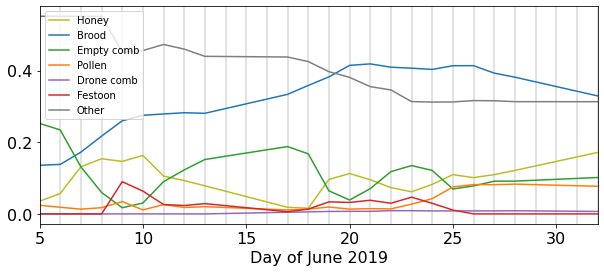

In [19]:
f,ax=plt.subplots(1,1)
f.set_size_inches(10,4)
tpx = np.arange(0,28)+junedaynumoffset
for i,label in enumerate(substrates_simple):
    ax.plot(tpx,all_overall_substrates_simple[0:len(tpx),i],label=label,color=substratecolors[i])
ax.set_xlabel('Day of June 2019',fontsize=16)
ax.tick_params(labelsize=16)
[ax.axvline(i,c='grey',alpha=0.3,zorder=-1) for i in tpx]
ax.set_xlim([5,32])
ax.legend()

In [20]:
all_overall_substrates_simple[23,0]

0.12139009352298187

## General - multiple quantities

In [190]:
savefigures = False
if savefigures:
    import matplotlib.backends.backend_pdf
    pdf = matplotlib.backends.backend_pdf.PdfPages('image-output/'+'Fig1-A-overtime.pdf')

In [191]:
workercolors = bp.snscolors[[1,8]]
dronecolors = bp.snscolors[[0,9]]

In [192]:
# make np data structures, because its easier/faster to calculate the quantiles below
# datacolnames = ['Num. observations','Honey', 'Brood care','Frame 2','Frame 5','Frame 5 - Num. crossings',
#                   'Median speed','Dispersion (avg)','Exit distance (median)','Out of hive']
datacolnames = ['Median speed','Dispersion (avg)','Exit distance (median)','Out of hive']

def getdatamat(df,datacolnames):
    datamat = df[datacolnames]
    datacolnames = datamat.columns
    datamat = np.array(datamat)

    timedivs = (np.array(df['Hour']) if numtimedivs==24 else np.array(df['timedivision']))
    timedivs_all = (timedivs + (np.array(df['Day number'])-daystoload[0])*numtimedivs).astype(int)
    return datamat, timedivs_all

datamat, timedivs_all = getdatamat(df,datacolnames)
datamat_drones1, timedivs_all_drones1 = getdatamat(df[(df['Cohort ID']==8)],datacolnames)
datamat_drones2, timedivs_all_drones2 = getdatamat(df[(df['Cohort ID']==10)],datacolnames)
datamat_workers1, timedivs_all_workers1 = getdatamat(df[(df['Cohort ID']==7)],datacolnames)
datamat_workers2, timedivs_all_workers2 = getdatamat(df[(df['Cohort ID']==9)],datacolnames)
datamat_allworkers, timedivs_all_allworkers = getdatamat(df[np.logical_not((df['Cohort ID']==8)|(df['Cohort ID']==10))],datacolnames)

In [257]:
# how many unique IDs for all workers?
wdfsel = df[np.logical_not((df['Cohort ID']==8)|(df['Cohort ID']==10))]
print('number of unique bees included in all workers: ',len(np.unique(wdfsel['Bee unique ID'])))

number of unique bees included in all workers:  3246


In [258]:
# how many unique IDs for all workers?
wdfsel = df[((df['Cohort ID']==8)|(df['Cohort ID']==10))]
print('number of unique drones included: ',len(np.unique(wdfsel['Bee unique ID'])))

number of unique drones included:  192


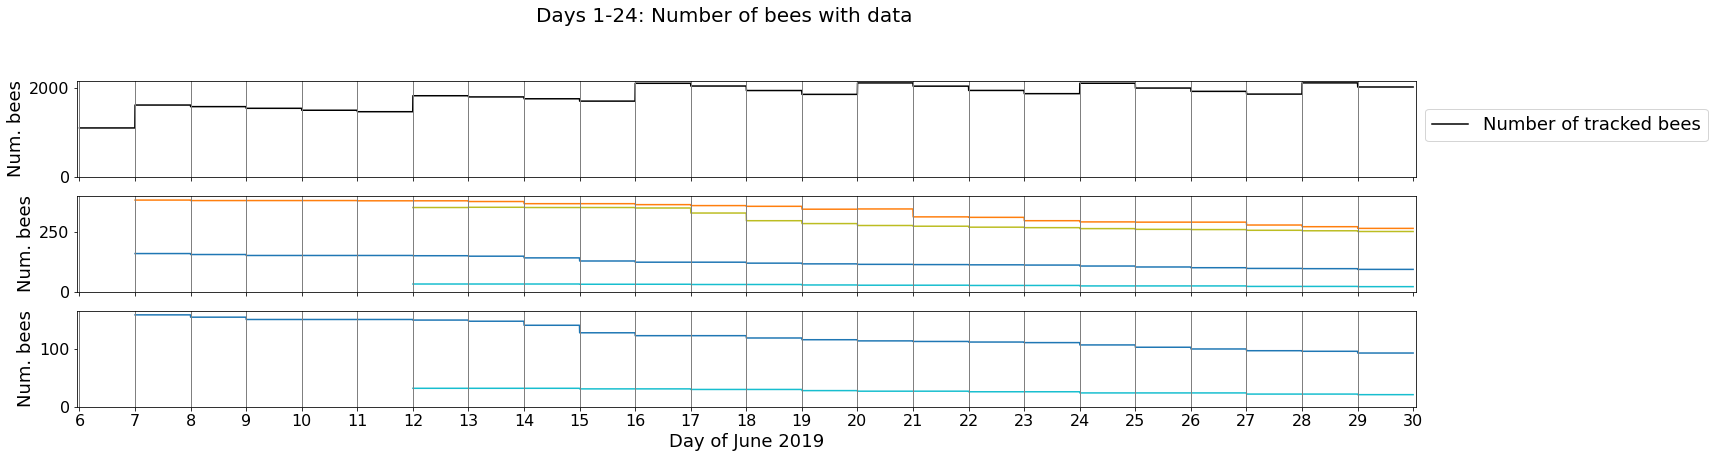

In [193]:
# number of bees counted over time
timebins = np.arange(numtimedivs*numdays+1)-0.5
def getnum(data):
    nums = scipy.stats.binned_statistic(data,np.ones(len(data)),bins=timebins,statistic=(lambda x: len(x)))[0] 
    nums[nums==0] = np.nan
    return nums
numbees_over_time = getnum(timedivs_all)
numdrones1_over_time = getnum(timedivs_all_drones1)
numdrones2_over_time = getnum(timedivs_all_drones2)
numworkers1_over_time = getnum(timedivs_all_workers1)
numworkers2_over_time = getnum(timedivs_all_workers2)

f,ax = plt.subplots(3,1,sharex=True,sharey=False)
f.set_size_inches(1*len(daystoload),2*3)

tpx = np.linspace(0,numdays,numtimedivs*numdays) + daystoload[0]

ax[0].plot(tpx,numbees_over_time,color='k',label='Number of tracked bees')
a=ax[1]
a.plot(tpx,numworkers1_over_time,color=workercolors[0],label='Workers in cohort 1')
a.plot(tpx,numworkers2_over_time,color=workercolors[1],label='Workers in cohort 2')    
for a in ax[1:3]:
    a.plot(tpx,numdrones1_over_time,color=dronecolors[0],label='Drones in cohort 1')
    a.plot(tpx,numdrones2_over_time,color=dronecolors[1],label='Drones in cohort 2')

for a in ax:
    a.set_ylabel('Num. bees',fontsize=18)
    a.set_ylim(bottom=0)
plt.suptitle('Days '+str(daystoload[0])+'-'+str(daystoload[-1])+": Number of bees with data",fontsize=20,y=1.05)

addlabels_and_formatting(ax)

pdf.savefig(f) if savefigures else None    
plt.show()

In [194]:
# calculate quantities in bins

skip=2
timebins = np.arange(numtimedivs*numdays+1)-0.5
timebins = timebins[::skip]  # works ok enough

l=len(timebins)-1
numq = len(datacolnames)
# quantities_over_time = np.zeros((l,numq,3))
# quantities_over_time_drones = np.zeros((l,numq,3))
means_over_time = np.zeros((l,numq,3))
means_over_time_drones1 = np.zeros((l,numq,3))
means_over_time_drones2 = np.zeros((l,numq,3))
means_over_time_workers1 = np.zeros((l,numq,3))
means_over_time_workers2 = np.zeros((l,numq,3))
means_over_time_allworkers = np.zeros((l,numq,3))


def getbinnedmeanstd(timedivs,data):
    mean = scipy.stats.binned_statistic(timedivs,data,bins=timebins,statistic=(lambda x: np.nanmean(x)))[0]
    std = scipy.stats.binned_statistic(timedivs,data,bins=timebins,statistic=(lambda x: np.nanstd(x)))[0]
    summed = scipy.stats.binned_statistic(timedivs,data,bins=timebins,statistic=(lambda x: np.nan if np.all(np.isnan(x)) else np.nansum(x)))[0]/skip  # this is for num bees
    return np.array((mean, std, summed)).T

import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)

    for enum in range(numq):
        print(enum,numq)
        means_over_time[:,enum] = getbinnedmeanstd(timedivs_all,datamat[:,enum])
        means_over_time_drones1[:,enum] = getbinnedmeanstd(timedivs_all_drones1,datamat_drones1[:,enum])
        means_over_time_drones2[:,enum] = getbinnedmeanstd(timedivs_all_drones2,datamat_drones2[:,enum])
        means_over_time_workers1[:,enum] = getbinnedmeanstd(timedivs_all_workers1,datamat_workers1[:,enum])
        means_over_time_workers2[:,enum] = getbinnedmeanstd(timedivs_all_workers2,datamat_workers2[:,enum])    
        means_over_time_allworkers[:,enum] = getbinnedmeanstd(timedivs_all_allworkers,datamat_allworkers[:,enum])    
        # this was to get quantiles - not using anymore
#         for j,qvalue in enumerate([0.25,0.5,0.75]):
#             quantities_over_time[:,enum,j] = scipy.stats.binned_statistic(timedivs_all,datamat[:,enum],bins=timebins,statistic=(lambda x: np.nanquantile(x,qvalue)))[0]
#             quantities_over_time_drones[:,enum,j] = scipy.stats.binned_statistic(timedivs_all_drones,datamat_drones[:,enum],bins=timebins,statistic=(lambda x: np.nanquantile(x,qvalue)))[0]

0 4
1 4
2 4
3 4


In [195]:
# set the start of the day when the cohort was introduced, to nan, so that its not shown
# assume daystoload[0] = 1
startdayfrac = 0.9
start = int(np.ceil((1*numtimedivs+startdayfrac*numtimedivs)/skip))
means_over_time_drones1[0:start] = np.nan
means_over_time_workers1[0:start] = np.nan
start = int(np.ceil((6*numtimedivs+startdayfrac*numtimedivs)/skip))
means_over_time_drones2[0:start] = np.nan
means_over_time_workers2[0:start] = np.nan

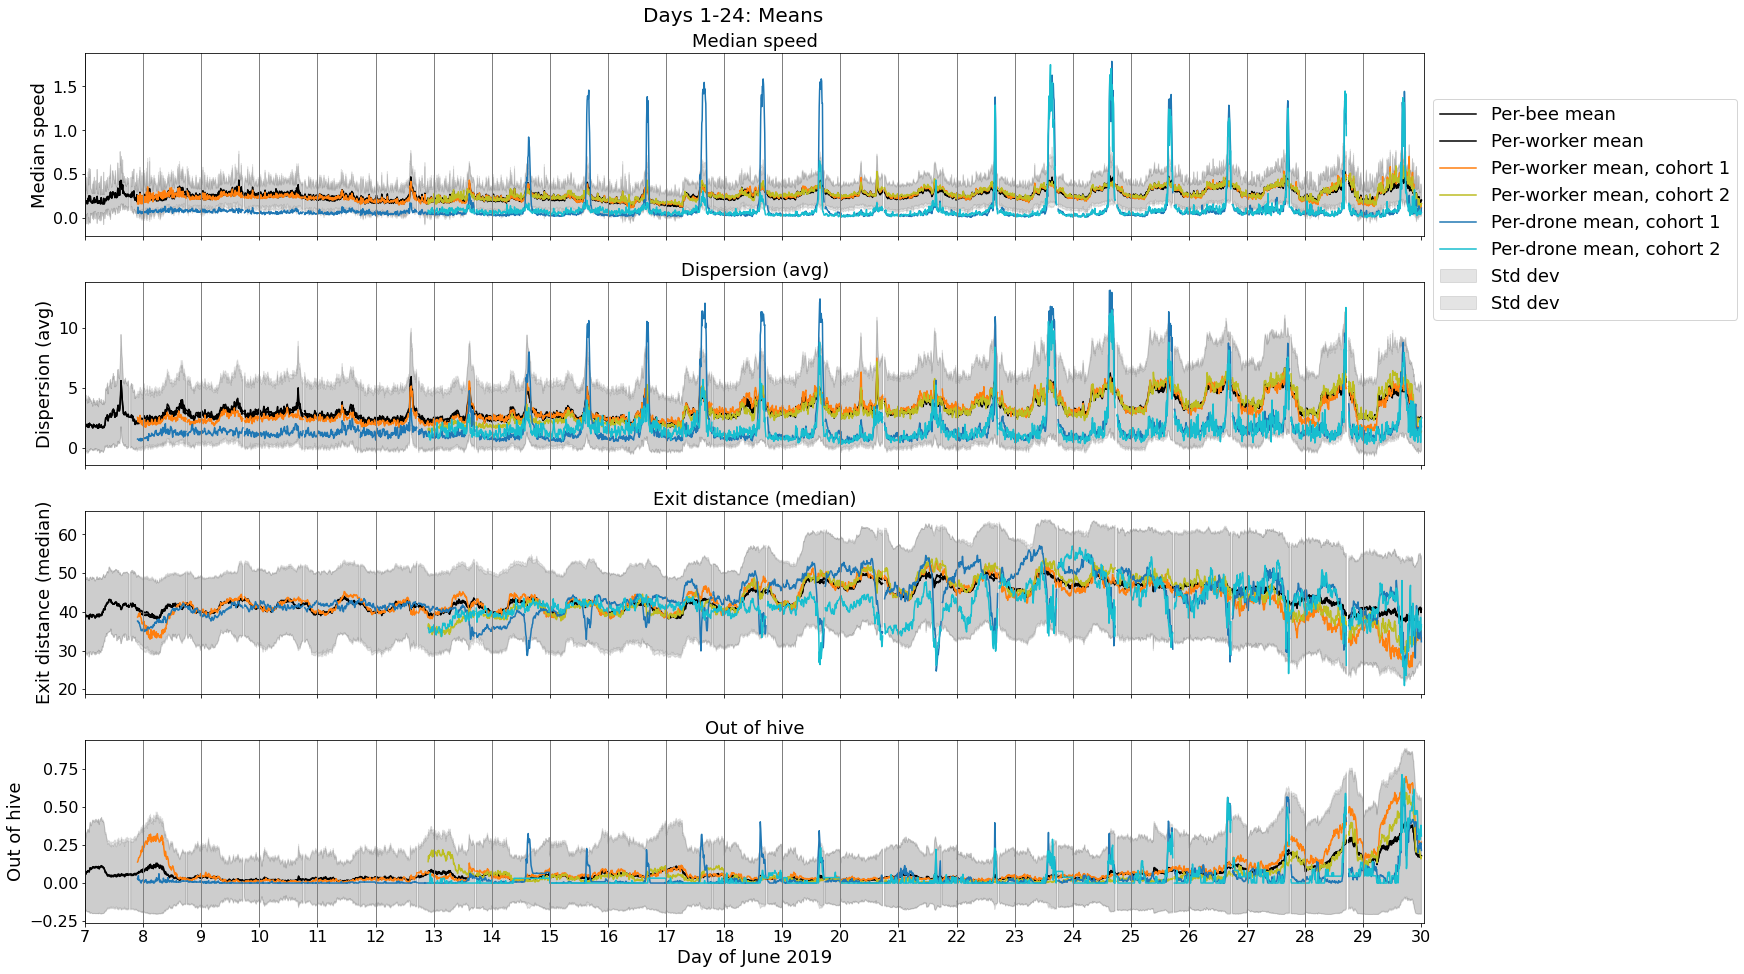

In [196]:
numev_toshow = numq
f,ax = plt.subplots(numev_toshow,1,sharex=True,sharey=False)
f.set_size_inches(1*len(daystoload),numev_toshow*4)

tpx = np.linspace(0,numdays,l) + daystoload[0]

def getyerror(data):
    y = data[:,0]
    error = y-data[:,1], y+data[:,1]
    return y,error

for enum in range(numq):
    a = ax[enum]
    # all bees
    y,error = getyerror(means_over_time[:,enum])
    a.plot(tpx,y,color='k',label='Per-bee mean')
    a.fill_between(tpx,error[0],error[1],color='k',alpha=0.1,label='Std dev')
    # all workers
    y,error = getyerror(means_over_time_allworkers[:,enum])
    a.plot(tpx,y,color='k',label='Per-worker mean')
    a.fill_between(tpx,error[0],error[1],color='k',alpha=0.1,label='Std dev')    
    # workers - 1
    y,error = getyerror(means_over_time_workers1[:,enum])
    a.plot(tpx,y,color=workercolors[0],label='Per-worker mean, cohort 1')
#     a.fill_between(tpx,error[0],error[1],color=bp.snscolors[2],alpha=0.1,label='Std dev')        
    # workers - 2
    y,error = getyerror(means_over_time_workers2[:,enum])
    a.plot(tpx,y,color=workercolors[1],label='Per-worker mean, cohort 2')
#     a.fill_between(tpx,error[0],error[1],color=bp.snscolors[3],alpha=0.1,label='Std dev')     
    # drones - 1
    y,error = getyerror(means_over_time_drones1[:,enum])
    a.plot(tpx,y,color=dronecolors[0],label='Per-drone mean, cohort 1')
#     a.fill_between(tpx,error[0],error[1],color=bp.snscolors[0],alpha=0.1,label='Std dev')    
    # drones - 2
    y,error = getyerror(means_over_time_drones2[:,enum])
    a.plot(tpx,y,color=dronecolors[1],label='Per-drone mean, cohort 2')
#     a.fill_between(tpx,error[0],error[1],color=bp.snscolors[1],alpha=0.1,label='Std dev')     
    # title, formatting
    a.set_title(datacolnames[enum],fontsize=18)
    a.set_ylabel(datacolnames[enum],fontsize=18)
plt.suptitle('Days '+str(daystoload[0])+'-'+str(daystoload[-1])+': Means',fontsize=20,y=0.92)
plt.subplots_adjust(hspace=0.25)
addlabels_and_formatting(ax)
ax[0].set_xlim(left=2)
pdf.savefig(f) if savefigures else None
plt.show()

## Specific quantities only

In [197]:
whichquantities = ['Median speed','Out of hive']
focusindices = [np.where(np.array(datacolnames)==w)[0][0] for w in whichquantities]
focusindices

[0, 3]

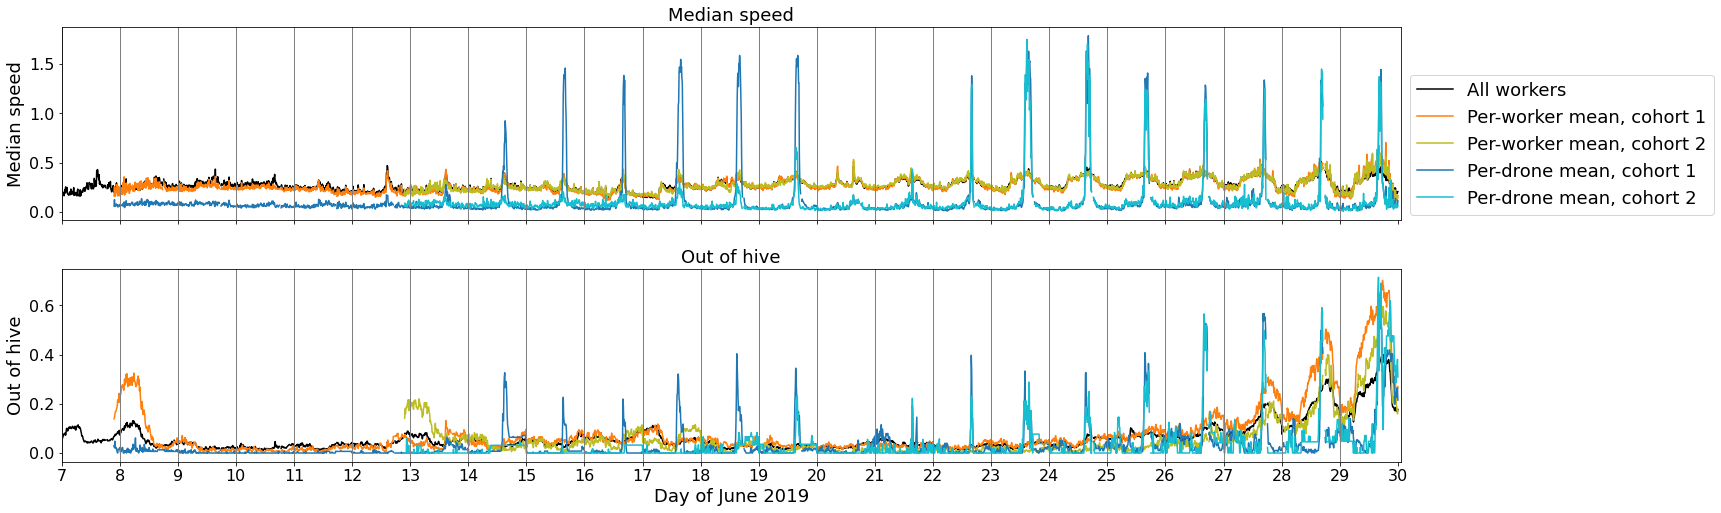

In [198]:

f,ax = plt.subplots(len(focusindices),1,sharex=True,sharey=False)
f.set_size_inches(1*len(daystoload),len(focusindices)*4)

tpx = np.linspace(0,numdays,l) + daystoload[0]

def getyerror(data):
    y = data[:,0]
    error = y-data[:,1], y+data[:,1]
    return y,error

for i,enum in enumerate(focusindices):
    a = ax[i]
    # all bees or all workers
    y,error = getyerror(means_over_time_allworkers[:,enum])
    a.plot(tpx,y,color='k',label='All workers')
#     a.fill_between(tpx,error[0],error[1],color='k',alpha=0.1,label='Std dev')
    # workers - 1
    y,error = getyerror(means_over_time_workers1[:,enum])
    a.plot(tpx,y,color=workercolors[0],label='Per-worker mean, cohort 1')
#     a.fill_between(tpx,error[0],error[1],color=bp.snscolors[2],alpha=0.1,label='Std dev')        
    # workers - 2
    y,error = getyerror(means_over_time_workers2[:,enum])
    a.plot(tpx,y,color=workercolors[1],label='Per-worker mean, cohort 2')
#     a.fill_between(tpx,error[0],error[1],color=bp.snscolors[3],alpha=0.1,label='Std dev')     
    # drones - 1
    y,error = getyerror(means_over_time_drones1[:,enum])
    a.plot(tpx,y,color=dronecolors[0],label='Per-drone mean, cohort 1')
#     a.fill_between(tpx,error[0],error[1],color=bp.snscolors[0],alpha=0.1,label='Std dev')    
    # drones - 2
    y,error = getyerror(means_over_time_drones2[:,enum])
    a.plot(tpx,y,color=dronecolors[1],label='Per-drone mean, cohort 2')
#     a.fill_between(tpx,error[0],error[1],color=bp.snscolors[1],alpha=0.1,label='Std dev')     
    # title, formatting
    a.set_title(datacolnames[enum],fontsize=18)
    a.set_ylabel(datacolnames[enum],fontsize=18)
# plt.suptitle('Days '+str(daystoload[0])+'-'+str(daystoload[-1])+': Means',fontsize=20,y=0.92)
plt.subplots_adjust(hspace=0.25)
addlabels_and_formatting(ax)
ax[0].set_xlim(left=2)
pdf.savefig(f) if savefigures else None
plt.savefig('image-output/fig1temp.pdf')
plt.show()

In [199]:
pdf.close() if savefigures else None
savefigures=False

## B - Histograms

In [24]:
savefigures = False
if savefigures:
    import matplotlib.backends.backend_pdf
    pdf = matplotlib.backends.backend_pdf.PdfPages('image-output/'+'Fig1-B-hists.pdf')

In [25]:
## importing the required  dataframe to create the XY-Histogramms 
daystoloadxy = np.arange(0,25,5)+3

for i,daynum in enumerate(daystoloadxy):
    filename = resultsdir+'dfxy_'+'dayhour'+'_'+str(daynum).zfill(zfilln)+'.pklz'
    if i==0:
        [dfxy] = pickle.load(gzip.open(filename,'rb'))
    else:
        dfxy = pd.concat((dfxy,pickle.load(gzip.open(filename,'rb'))[0]))

In [26]:
def dark_bg_display_hack(ax):
    for a in ax:
        a.set_yticks([0])  # hack to show up on dark background
        a.set_yticklabels([''])
        a.tick_params(length=0)

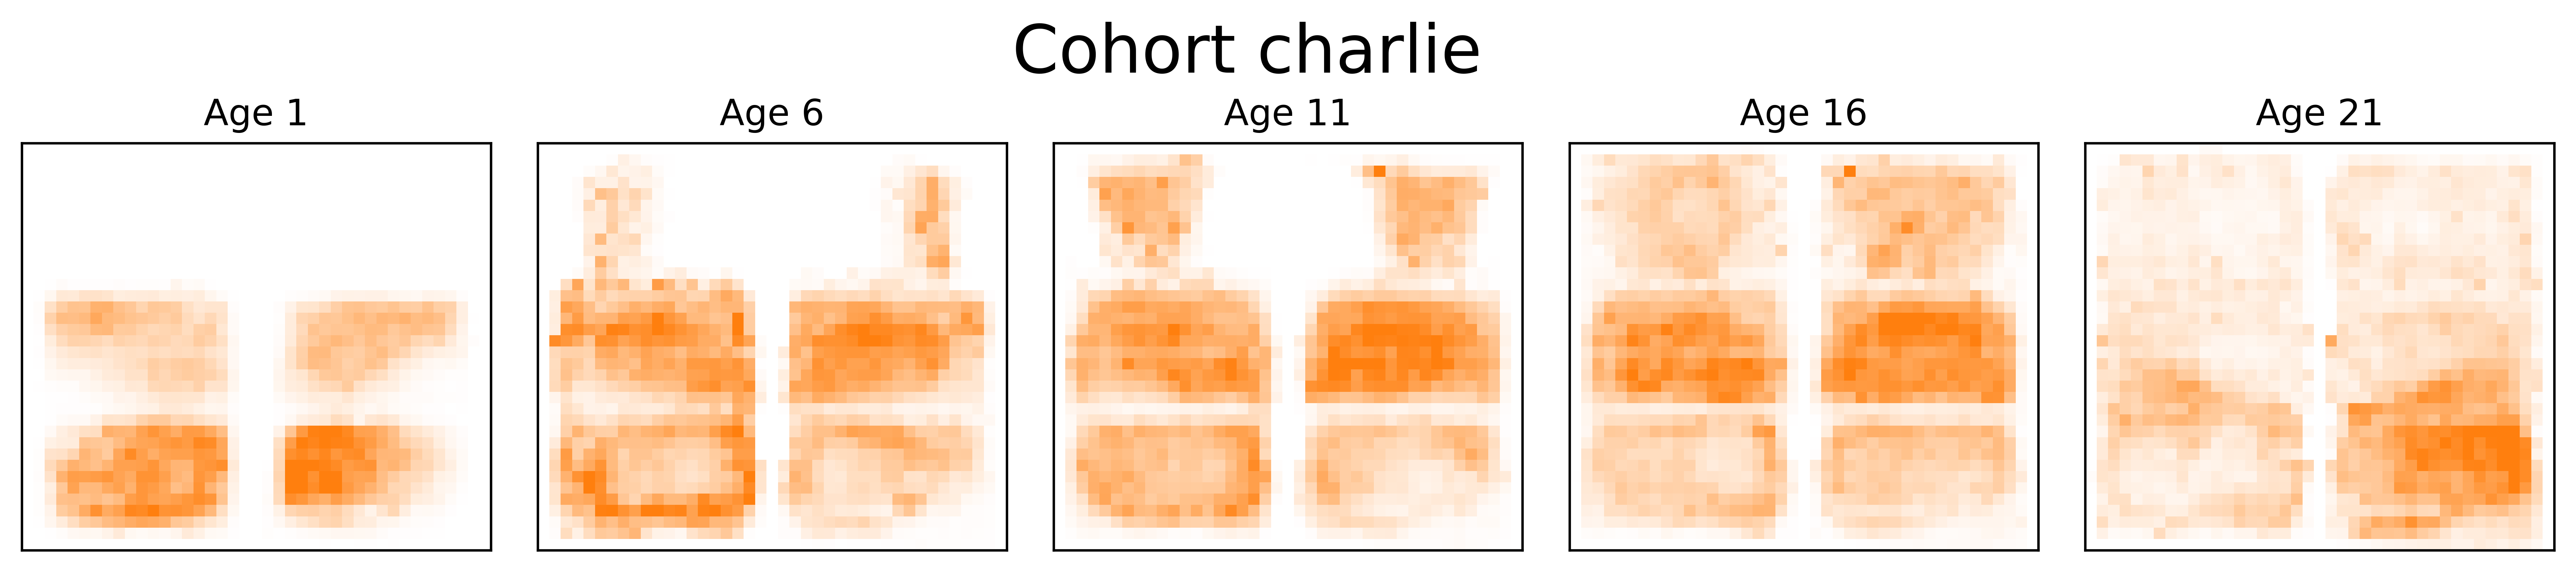

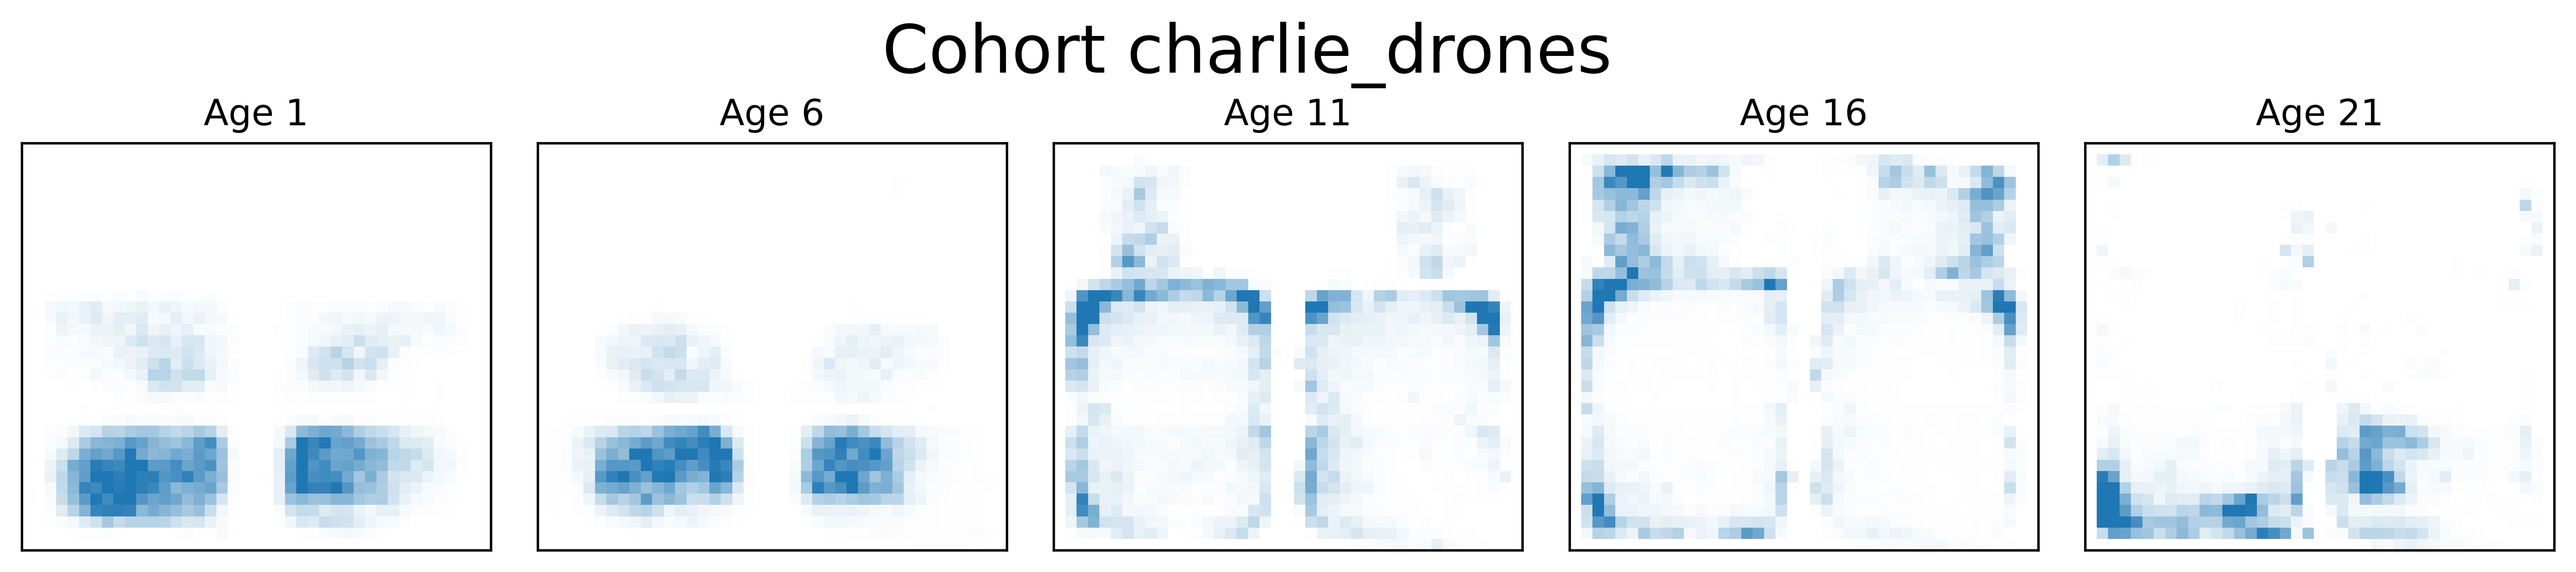

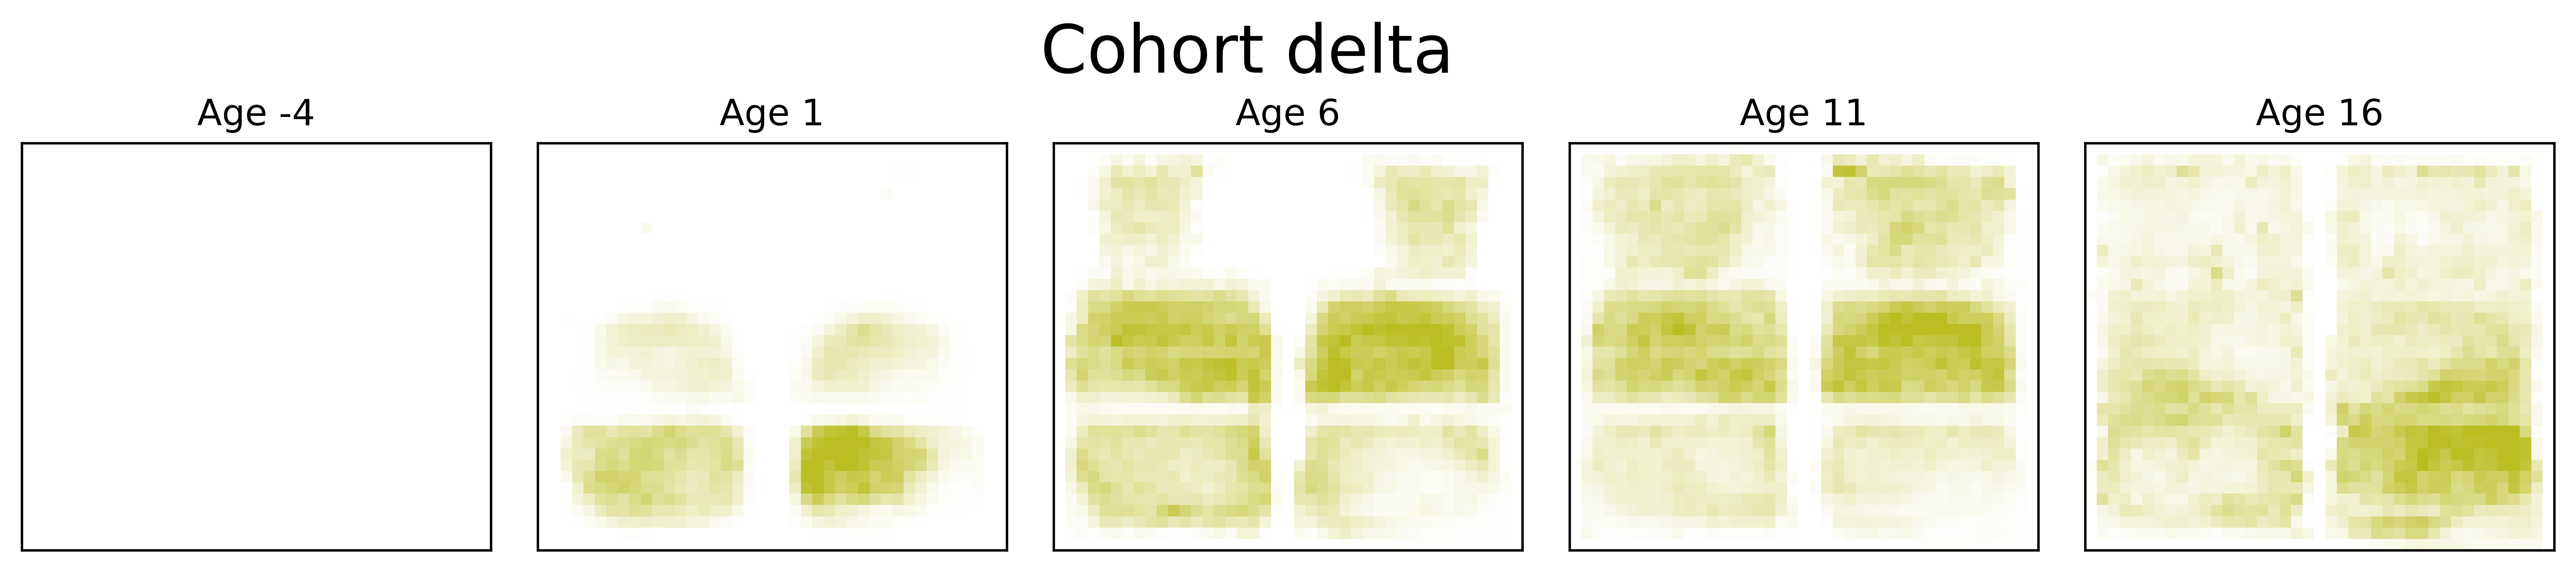

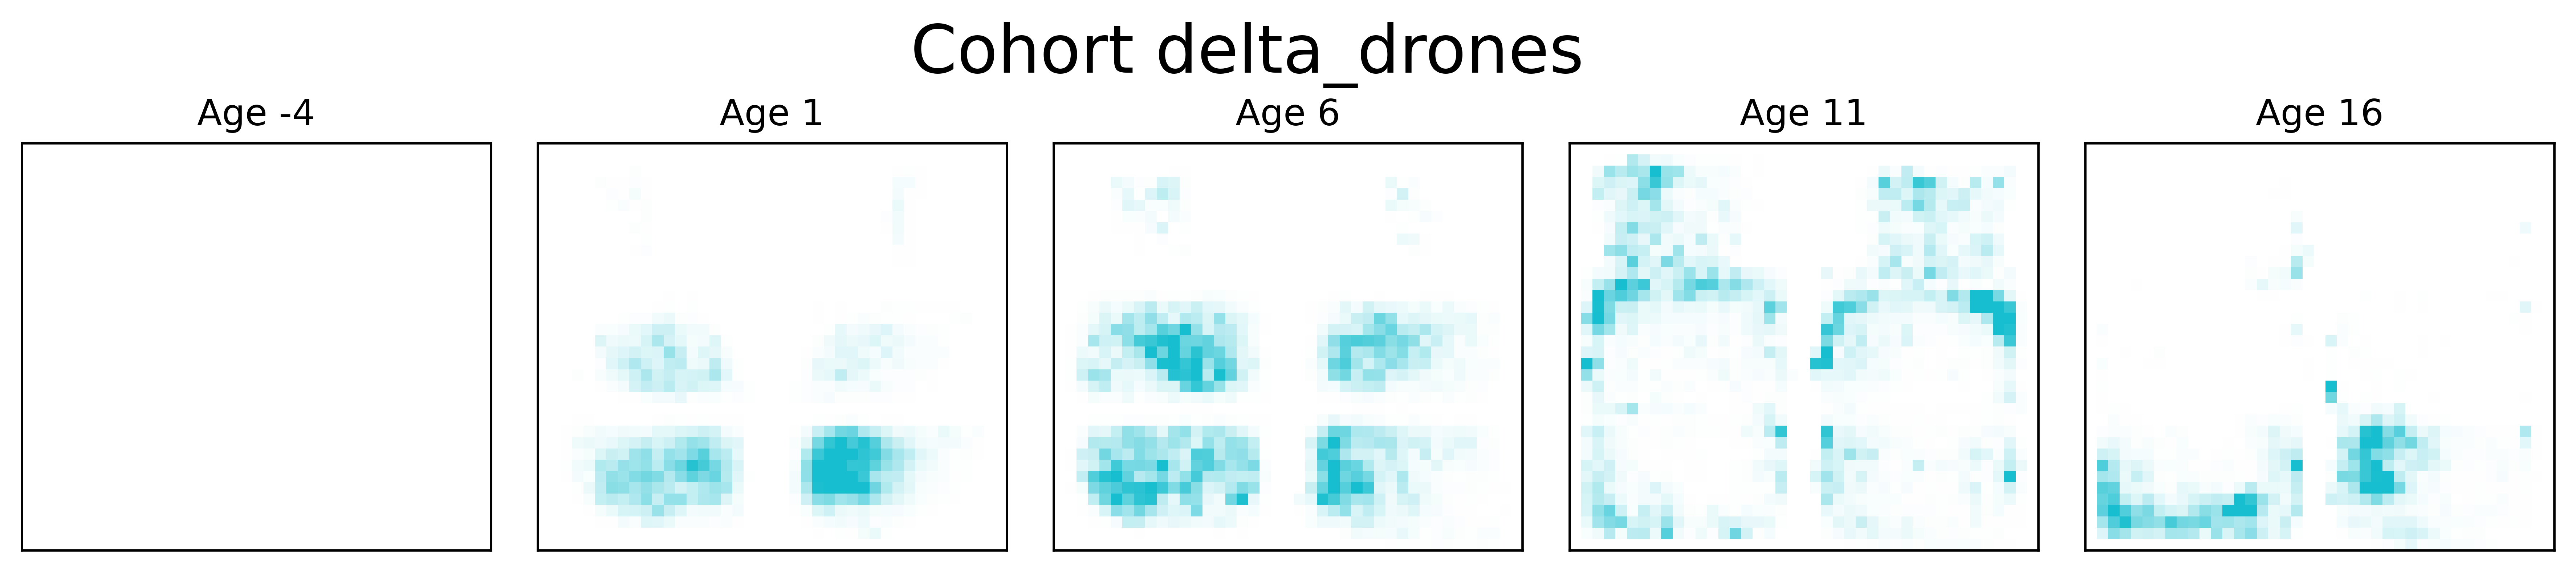

In [27]:
# Plot an example:  bees of a certain cohort, for each day loaded
cohortnum=8
tpcolors = [workercolors[0],dronecolors[0],workercolors[1],dronecolors[1]]
for cohortnum,color in zip([7,8,9,10],tpcolors):

    sel = (dfxy['Cohort ID']==cohortnum)
    bdaydaynum = np.where(bd.alldaytimestamps==bd.cohort_birthdates[cohortnum])[0][0]

    numcols = len(daystoloadxy)
    f,ax = plt.subplots(1,numcols,sharex=True,sharey=True)
    f.set_size_inches(numcols*3,3)
    f.set_dpi(600)
    for i,daynum in enumerate(daystoloadxy):
        a=ax[i]
        dayhist = dfunc.flat_to_hist(np.mean(dfxy[sel & (dfxy['Day number']==daynum)],axis=0))
        bp.showhist(dayhist,ax=a,color=color)
        a.set_title('Age '+str(daynum-bdaydaynum))
    plt.suptitle('Cohort '+bd.cohort_names[cohortnum],fontsize=22,y=1)
    dark_bg_display_hack(ax)
    plt.subplots_adjust(wspace=0.1)
    pdf.savefig(f) if savefigures else None
    plt.show()


In [28]:
# allcomb = [dfunc.day_comb_data(comb_contents_dir,bd.alldaytimestamps[daynum]) for daynum in bd.comb_daynums]
# faster way to load - use the pickle files
allcomb = [pickle.load(gzip.open(comb_contents_dir+'comb_'+str(daynum).zfill(zfilln)+'.pklz','rb')) for daynum in daystoloadxy]

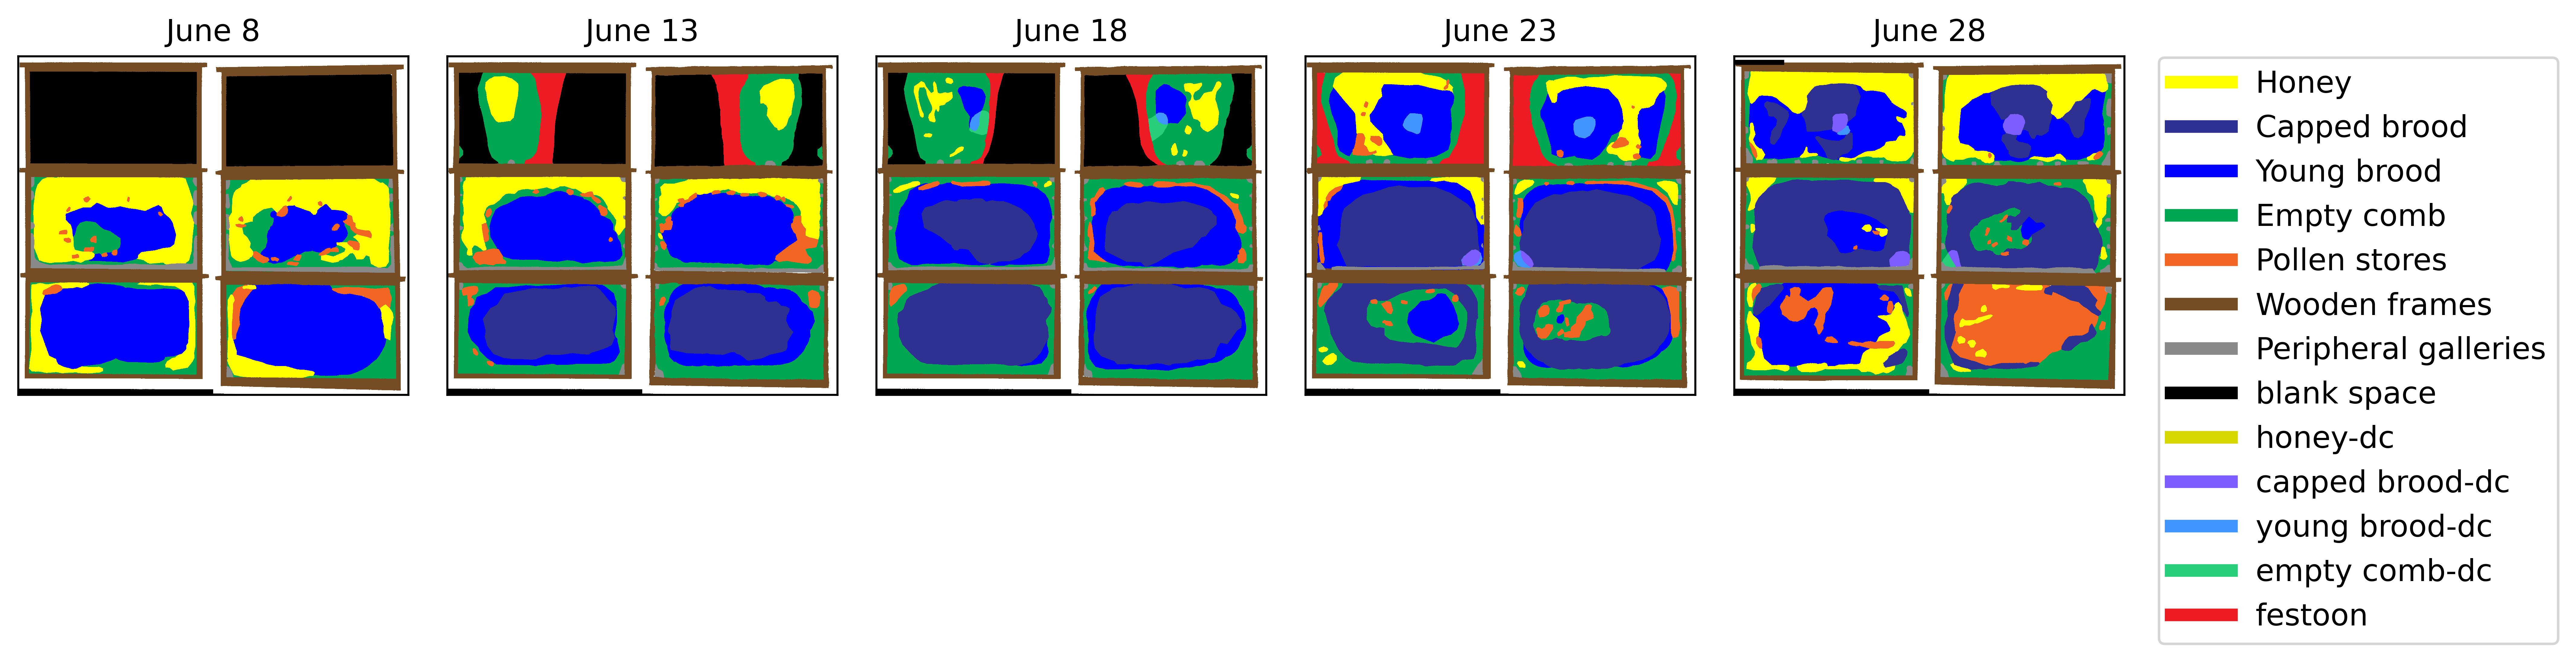

In [29]:
# plot all comb measurements along a line
numcols = len(daystoloadxy)
f,ax = plt.subplots(1,numcols,sharex=True,sharey=True)
f.set_size_inches(numcols*3,3)
f.set_dpi(600)
fontsize=12

# f,ax = plt.subplots(1,len(,sharex=True,sharey=True)
# basesize=10
# # fontsize=basesize*3
# f.set_size_inches(basesize*ax.shape[1],basesize*ax.shape[0]*(bd.ypixels/(2*bd.xpixels)))

for i,daynum in enumerate(daystoloadxy):
    a=ax[i]
    bp.showcomb(allcomb[i],ax=a)
    a.set_title('June '+str(daynum+junedaynumoffset),fontsize=fontsize)
plt.subplots_adjust(wspace=0.1)

# legend hack
a = ax[-1]
for i in range(len(bd.substrate_names)-1):
    if i==5:  # dance floor
#         a.plot(0,0,label='Dances observed',c=bd.cmap_comb(i),lw=5)
#         a.plot(0,0,label='Dance floor (combined)',linestyle='--',lw=5,c=bd.cmap_comb(i))        
        None
    else:
        a.plot(0,0,label=bd.substrate_names[i],c=bd.cmap_comb(i),lw=5)
a.legend(fontsize=fontsize,bbox_to_anchor=(1.05, 1.04))
linelength=10 # in cm
a.plot([0,0+linelength*bd.pixels_per_cm],[100,100],linewidth=2,color='k')
dark_bg_display_hack(ax)
pdf.savefig(f) if savefigures else None
# plt.savefig('image-output/temp.pdf')
plt.show()


In [30]:
pdf.close() if savefigures else None
savefigures=False

In [31]:
savefigures

False

## Supp - Histograms

In [32]:
savefigures = True
if savefigures:
    import matplotlib.backends.backend_pdf
    pdf = matplotlib.backends.backend_pdf.PdfPages('image-output/'+'Supp-allhists.pdf')

In [33]:
## importing the required  dataframe to create the XY-Histogramms 
daystoloadxy = np.arange(3,25,1)

for i,daynum in enumerate(daystoloadxy):
    filename = resultsdir+'dfxy_'+'dayhour'+'_'+str(daynum).zfill(zfilln)+'.pklz'
    if i==0:
        [dfxy] = pickle.load(gzip.open(filename,'rb'))
    else:
        dfxy = pd.concat((dfxy,pickle.load(gzip.open(filename,'rb'))[0]))

In [34]:
def dark_bg_display_hack(ax):
    for a in ax:
        a.set_yticks([0])  # hack to show up on dark background
        a.set_yticklabels([''])
        a.tick_params(length=0)

In [ ]:
# Plot an example:  bees of a certain cohort, for each day loaded
cohortnum=8
tpcolors = [workercolors[0],dronecolors[0],workercolors[1],dronecolors[1]]
for cohortnum,color in zip([7,8,9,10],tpcolors):

    sel = (dfxy['Cohort ID']==cohortnum)
    bdaydaynum = np.where(bd.alldaytimestamps==bd.cohort_birthdates[cohortnum])[0][0]

    numcols = len(daystoloadxy)
    f,ax = plt.subplots(1,numcols,sharex=True,sharey=True)
    f.set_size_inches(numcols*3,3)
    f.set_dpi(600)
    for i,daynum in enumerate(daystoloadxy):
        a=ax[i]
        dayhist = dfunc.flat_to_hist(np.mean(dfxy[sel & (dfxy['Day number']==daynum)],axis=0))
        bp.showhist(dayhist,ax=a,color=color)
        a.set_title('Age '+str(daynum-bdaydaynum))
    plt.suptitle('Cohort '+bd.cohort_names[cohortnum],fontsize=22,y=1)
    dark_bg_display_hack(ax)
    plt.subplots_adjust(wspace=0.1)
    pdf.savefig(f) if savefigures else None
    plt.show()


In [ ]:
# allcomb = [dfunc.day_comb_data(comb_contents_dir,bd.alldaytimestamps[daynum]) for daynum in bd.comb_daynums]
# faster way to load - use the pickle files
allcomb = [pickle.load(gzip.open(comb_contents_dir+'comb_'+str(daynum).zfill(zfilln)+'.pklz','rb')) for daynum in daystoloadxy]

In [ ]:
# plot all comb measurements along a line
numcols = len(daystoloadxy)
f,ax = plt.subplots(1,numcols,sharex=True,sharey=True)
f.set_size_inches(numcols*3,3)
f.set_dpi(600)
fontsize=12

# f,ax = plt.subplots(1,len(,sharex=True,sharey=True)
# basesize=10
# # fontsize=basesize*3
# f.set_size_inches(basesize*ax.shape[1],basesize*ax.shape[0]*(bd.ypixels/(2*bd.xpixels)))

for i,daynum in enumerate(daystoloadxy):
    a=ax[i]
    bp.showcomb(allcomb[i],ax=a)
    a.set_title('June '+str(daynum+junedaynumoffset),fontsize=fontsize)
plt.subplots_adjust(wspace=0.1)

# legend hack
a = ax[-1]
for i in range(len(bd.substrate_names)-1):
    if i==5:  # dance floor
#         a.plot(0,0,label='Dances observed',c=bd.cmap_comb(i),lw=5)
#         a.plot(0,0,label='Dance floor (combined)',linestyle='--',lw=5,c=bd.cmap_comb(i))        
        None
    else:
        a.plot(0,0,label=bd.substrate_names[i],c=bd.cmap_comb(i),lw=5)
a.legend(fontsize=fontsize,bbox_to_anchor=(1.05, 1.04))
linelength=10 # in cm
a.plot([0,0+linelength*bd.pixels_per_cm],[100,100],linewidth=2,color='k')
dark_bg_display_hack(ax)
pdf.savefig(f) if savefigures else None
plt.savefig('image-output/temp.pdf')
plt.show()


In [ ]:
pdf.close() if savefigures else None
savefigures=False

In [ ]:
savefigures

# (Fig 2-3) Rhythms, over time

## Definitions of threshold

In [24]:
qv = np.arange(.7,0.99,0.05)
pd.DataFrame(np.array([qv,np.nanquantile(df['Median speed'],qv)]).T,columns=['Quantile','Value for all tracked bees'])

Quantile  Value for all tracked bees
0      0.70                    0.315910
1      0.75                    0.337500
2      0.80                    0.358482
3      0.85                    0.398630
4      0.90                    0.456207
5      0.95                    0.536918

In [25]:
speedthreshold = 0.5
np.mean(df.loc[np.logical_not(np.isnan(df['Median speed'])),'Median speed']<speedthreshold)

0.928588938446016

## Collective activation time
Note that with this definition, the collective activation time is INCLUSIVE of the last point. i.e should use <= act[1]

In [185]:
daynumstoshow = np.arange(8,25)

In [186]:
## Collective activation time
collectivethreshold=0.25
speedthreshold = 0.5
showplots = False
collectiveactivated = []
mindiv = 12*12
maxdiv = 18*12
for daynum in daynumstoshow:
    # both if age>=7
    if daynum>=14:  # use both cohorts from this day on, because the younger cohort didn't really activate before this
        dfdrones = df[((df['Cohort ID']==8)|(df['Cohort ID']==10))&(df['Day number']==daynum)]
    else:
        dfdrones = df[((df['Cohort ID']==8))&(df['Day number']==daynum)]
    
    speedvals = dfdrones.pivot("Bee unique ID", 'timedivision', 'Median speed').values[:,mindiv:maxdiv]
    outvals = dfdrones.pivot("Bee unique ID", 'timedivision', 'Out of hive').values[:,mindiv:maxdiv]

    activated = (speedvals>speedthreshold) | (outvals==1)
    groupactivated = np.mean(activated,axis=0)
    results = np.where(groupactivated>collectivethreshold)[0]
    if len(results)==0:
        collectiveactivated.append([-1,-1])
    else:
        collectiveactivated.append([results[0]+mindiv,results[-1]+mindiv])

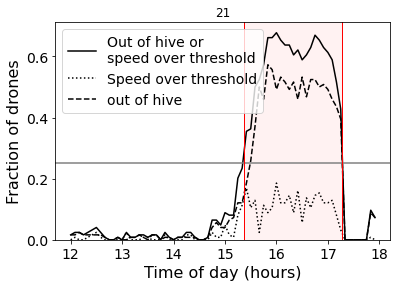

In [187]:
# Show a single daynum plot, to show how the definition is done
daynum=21
if daynum>=14:  # use both cohorts from this day on, because the younger cohort didn't really activate before this
    dfdrones = df[((df['Cohort ID']==8)|(df['Cohort ID']==10))&(df['Day number']==daynum)]
else:
    dfdrones = df[((df['Cohort ID']==8))&(df['Day number']==daynum)]

speedvals = dfdrones.pivot("Bee unique ID", 'timedivision', 'Median speed').values[:,mindiv:maxdiv]
outvals = dfdrones.pivot("Bee unique ID", 'timedivision', 'Out of hive').values[:,mindiv:maxdiv]

speedthreshold = 0.5
activated = (speedvals>speedthreshold) | (outvals==1)
groupactivated = np.mean(activated,axis=0)
results = np.where(groupactivated>collectivethreshold)[0]

f,ax = plt.subplots(1,1)
f.set_size_inches(6,4)
tpx = (np.arange(len(groupactivated))+mindiv)/12
plt.plot(tpx,groupactivated,label='Out of hive or\nspeed over threshold',c='k')
plt.plot(tpx,np.mean(speedvals>speedthreshold,axis=0),label='Speed over threshold',linestyle=':',c='k')
plt.plot(tpx,np.mean(outvals==1,axis=0),label='out of hive',linestyle='--',c='k')    
plt.title(daynum)
plt.axhline(collectivethreshold,c='grey',linewidth=1.5,linestyle='-')
act = np.array([results[0]+mindiv,results[-1]+mindiv])
act = act/(numtimedivs)*24*287/288
plt.axvline(act[0],c='r',linewidth=1)
plt.axvline(act[1]+1/12,c='r',linewidth=1)
plt.axvspan(act[0],act[1]+1/12,color='r',alpha=0.05,zorder=-1)
plt.ylim(bottom=0)
plt.legend(fontsize=14)
plt.tick_params(labelsize=14)
plt.xlabel('Time of day (hours)',fontsize=16)
plt.ylabel('Fraction of drones',fontsize=16)
plt.savefig('image-output/activation-definition.pdf')
plt.show()

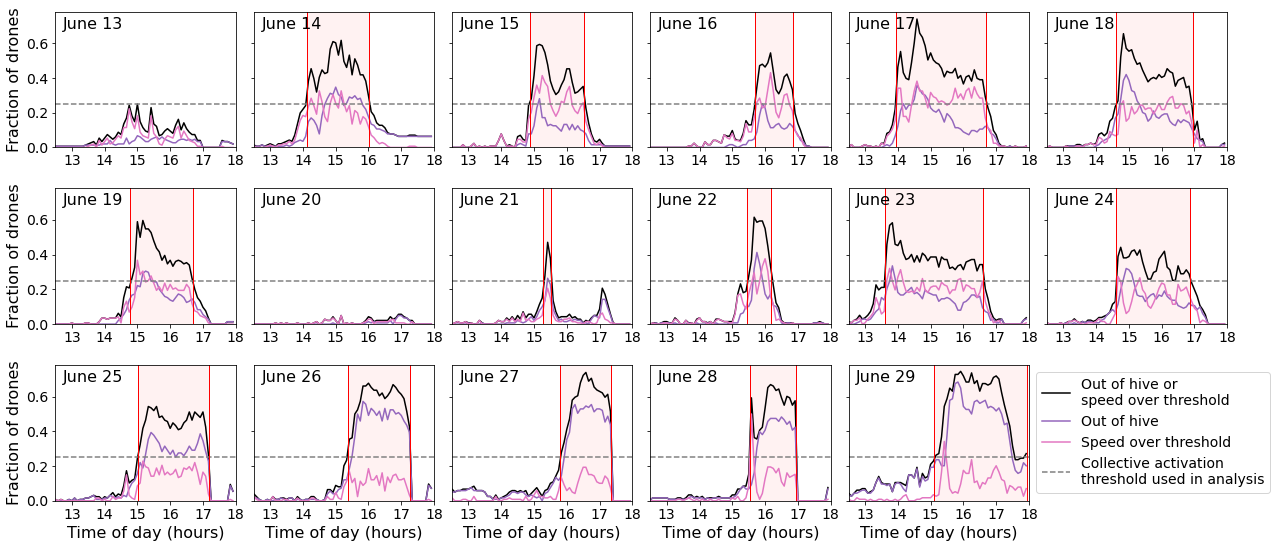

In [29]:
# Show all daynumstoshow.
numrows=3
numcols=np.ceil(len(daynumstoshow)/numrows).astype(int)

f,ax = plt.subplots(numrows,numcols,sharey=True,sharex='row')
f.set_size_inches(3.5*numcols,3*numrows)

daynum=21
for i,daynum in enumerate(daynumstoshow):
    r,c = np.divmod(i,numcols)
    a=ax[r,c]

    if daynum>=14:  # use both cohorts from this day on, because the younger cohort didn't really activate before this
        dfdrones = df[((df['Cohort ID']==8)|(df['Cohort ID']==10))&(df['Day number']==daynum)]
    else:
        dfdrones = df[((df['Cohort ID']==8))&(df['Day number']==daynum)]

    speedvals = dfdrones.pivot("Bee unique ID", 'timedivision', 'Median speed').values[:,mindiv:maxdiv]
    outvals = dfdrones.pivot("Bee unique ID", 'timedivision', 'Out of hive').values[:,mindiv:maxdiv]

    speedthreshold = 0.5
    activated = (speedvals>speedthreshold) | (outvals==1)
    groupactivated = np.mean(activated,axis=0)
    results = np.where(groupactivated>collectivethreshold)[0]

    tpx = (np.arange(len(groupactivated))+mindiv)/12
    a.plot(tpx,groupactivated,label='Out of hive or\nspeed over threshold',c='k')
    a.plot(tpx,np.mean(outvals==1,axis=0),label='Out of hive',linestyle='-',c=bp.snscolors[4])    
    a.plot(tpx,np.mean(speedvals>speedthreshold,axis=0),label='Speed over threshold',linestyle='-',c=bp.snscolors[6])
    
    a.axhline(collectivethreshold,linestyle='--',label='Collective activation\nthreshold used in analysis',color='grey')
    
    if len(results)>0:
        act = np.array([results[0]+mindiv,results[-1]+mindiv])
        act = act/(numtimedivs)*24*287/288
        a.axvline(act[0],c='r',linewidth=1)
        a.axvline(act[1]+1/12,c='r',linewidth=1)
        a.axvspan(act[0],act[1]+1/12,color='r',alpha=0.05,zorder=-1)
    
    a.tick_params(labelsize=14)
    a.set_title('June '+str(daynum+junedaynumoffset),fontsize=16,x=0.21,y=0.83)
    a.set_xticks(np.arange(13,19))
    a.set_xlim([12.5,18])
    
[a.set_xlabel('Time of day (hours)',fontsize=16) for a in ax[-1]]


ax[0,0].set_ylim(bottom=0)    
ax[-1,-2].legend(fontsize=14,bbox_to_anchor=(1,1))    
ax[-1,-1].axis('off')
[a.set_ylabel('Fraction of drones',fontsize=16) for a in ax[:,0]]
plt.subplots_adjust(wspace=0.1,hspace=0.3)
plt.savefig('image-output/activation-definition-all.pdf')
plt.show()

## Calculation on specific means

In [30]:
speedind=np.where(np.array(datacolnames)=='Median speed')[0][0]
datacolnames[speedind]

'Median speed'

In [31]:
# calculate quantities in bins

timebins = np.arange(numtimedivs*numdays+1)-0.5

l=len(timebins)-1
numq = len(datacolnames)
# quantities_over_time = np.zeros((l,numq,3))
# quantities_over_time_drones = np.zeros((l,numq,3))
speed_over_time_drones = np.zeros((l,3))
speed_over_time_workers = np.zeros((l,3))


def getbinnedmeanstd(timedivs,data):
    mean = scipy.stats.binned_statistic(timedivs,data,bins=timebins,statistic=(lambda x: np.nanmean(x)))[0]
    std = scipy.stats.binned_statistic(timedivs,data,bins=timebins,statistic=(lambda x: np.nanstd(x)))[0]
    summed = scipy.stats.binned_statistic(timedivs,data,bins=timebins,statistic=(lambda x: np.nan if np.all(np.isnan(x)) else np.nansum(x)))[0]  # this is for num bees
    return np.array((mean, std, summed)).T

import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    speed_over_time_drones = getbinnedmeanstd(np.concatenate((timedivs_all_drones1,timedivs_all_drones2)),np.concatenate((datamat_drones1[:,speedind],datamat_drones2[:,speedind])))
    speed_over_time_workers = getbinnedmeanstd(np.concatenate((timedivs_all_workers1,timedivs_all_workers2)),np.concatenate((datamat_workers1[:,speedind],datamat_workers2[:,speedind])))

In [32]:
def getperdaymax(means_over_time):
    return np.nanmax(np.reshape(means_over_time,(len(daystoload),int(numtimedivs))),axis=1)
dronemaxes = getperdaymax(speed_over_time_drones[:,0])
workermaxes = getperdaymax(speed_over_time_workers[:,0])

<ipython-input-32-56d37fa2238c>:2: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(np.reshape(means_over_time,(len(daystoload),int(numtimedivs))),axis=1)


In [33]:
printmeanstd = lambda vals: print(np.round(np.nanmean(vals),3),'+/-',np.round(np.nanstd(vals),3))
print('Drone maxes:')
printmeanstd(dronemaxes)
print('Worker maxes:')
printmeanstd(workermaxes)

Drone maxes:
0.905 +/- 0.56
Worker maxes:
0.454 +/- 0.076


In [34]:
## Only within collective activation period
dronespeeds = []
workerspeeds = []
for i,daynum in enumerate(daynumstoshow):
    act = collectiveactivated[i]
    if act[0]>-1:
        dronespeeds.append(df.loc[((df['Cohort ID']==8)|(df['Cohort ID']==10))&(df['Day number']==daynum)&(df['timedivision']>=act[0])&(df['timedivision']<=act[1]),'Median speed'].values)
        workerspeeds.append(df.loc[((df['Cohort ID']==7)|(df['Cohort ID']==9))&(df['Day number']==daynum)&(df['timedivision']>=act[0])&(df['timedivision']<=act[1]),'Median speed'].values)

In [35]:
print('Drone mean in activation period:')
printmeanstd(np.concatenate(dronespeeds))
print('Worker mean in activation period:')
printmeanstd(np.concatenate(workerspeeds))


Drone mean in activation period:
0.743 +/- 0.684
Worker mean in activation period:
0.371 +/- 0.213


## Speed and of hive, lined up

Note:  Could plot these for many quantities, or could just focus on the few quantities.  Or, could should other quantities in the supplementary

In [200]:
whichquantities = ['Median speed','Out of hive']
focusindices = [np.where(np.array(datacolnames)==w)[0][0] for w in whichquantities]
focusindices

[0, 3]

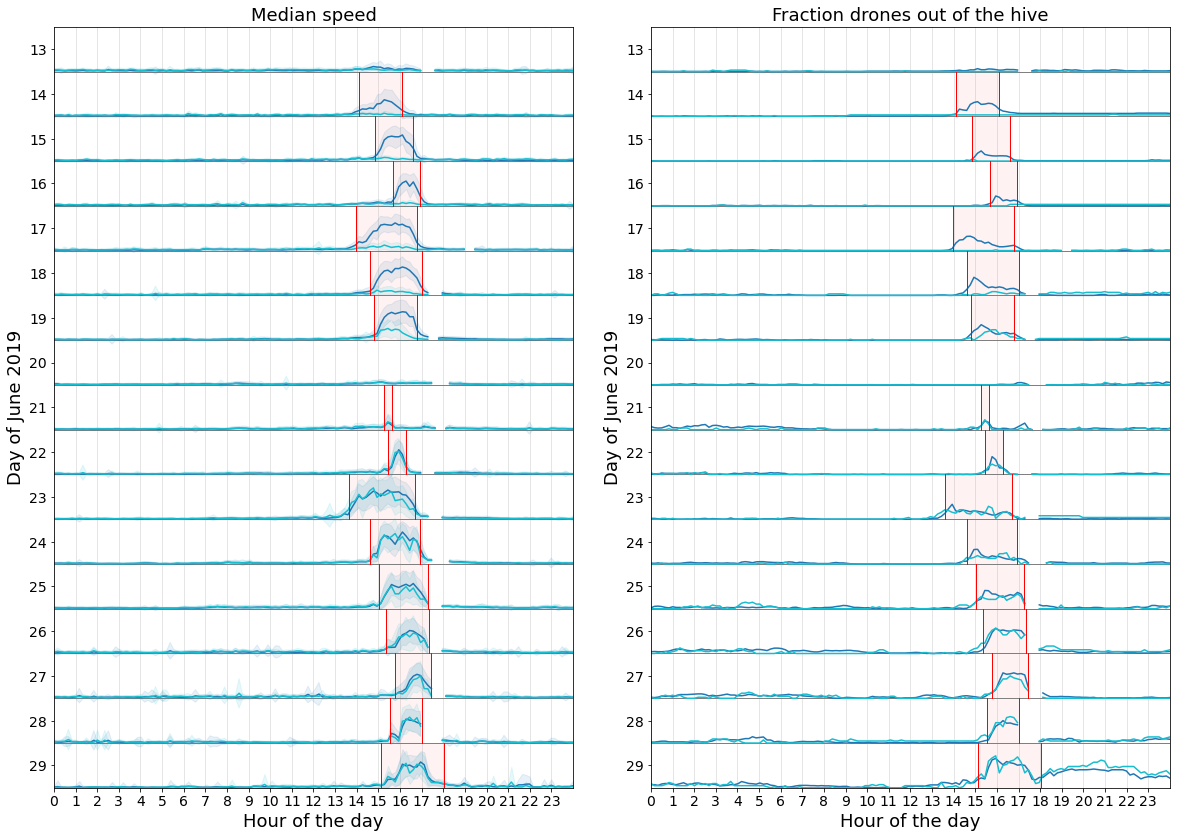

In [201]:
tpx = np.linspace(0,24,int(numtimedivs/skip))

def setaxvals(a,yshifts):
    [a.axvline(j,c='grey',linewidth=1,zorder=-1,alpha=0.2) for j in range(24)]    
    a.set_xlim([0,24])
    a.tick_params(labelsize=14)
    a.set_xlim([0,24])
    #ticks
    a.set_xticks(np.arange(24))
    a.set_xticklabels(np.arange(24))
    a.set_yticks(np.array(yshifts)+yshift/2)
    a.set_yticklabels(daynumstoshow+junedaynumoffset)
    # title and labels
    a.set_xlabel('Hour of the day',fontsize=18)
    a.set_ylabel('Day of June 2019',fontsize=18)

    yshifts = np.insert((yshifts),0,yshifts[0]+yshift)
    a.set_ylim([yshifts[-1],yshifts[0]])
    for i,act in enumerate(np.array(collectiveactivated)):
        ymax, ymin = (yshifts[i])/yshifts[0], (yshifts[i+1])/yshifts[0]
        act = act/(numtimedivs)*24*287/288  # looks reasonable, I didn't do the linspace the most exact way though
        if act[0]>0:
            a.axvline(act[0],c='r',ymin=ymin,ymax=ymax,linewidth=1)
            a.axvline(act[1]+2/12,c='r',ymin=ymin,ymax=ymax,linewidth=1)    
            a.axvspan(act[0],act[1]+2/12,color='r',alpha=0.05,zorder=-1,ymin=ymin,ymax=ymax)

f,ax=plt.subplots(1,2,sharex=True,sharey=False)
f.set_size_inches(20,14)

# Median speed
k=0
enum=focusindices[k]
a=ax[k]
selind = [0,2][k]
y1_perday = np.reshape(means_over_time_drones1[:,enum,selind],(-1,len(tpx)))
ystd1_perday = np.reshape(means_over_time_drones1[:,enum,1],(-1,len(tpx)))
y2_perday = np.reshape(means_over_time_drones2[:,enum,selind],(-1,len(tpx)))
ystd2_perday = np.reshape(means_over_time_drones2[:,enum,1],(-1,len(tpx)))
y_perday = y1_perday+y2_perday
yshift = 2.5

yshifts=[]
for daynum in daynumstoshow:
    i = np.where(daynum==daystoload)[0][0]
    offset=yshift*(24-i-1)
    yshifts.append(offset)
    a.axhline(offset,linewidth=1,zorder=-1,alpha=1,c='grey')
    for y_perday,ystd_perday,color in zip([y1_perday,y2_perday],[ystd1_perday,ystd2_perday],dronecolors):
        a.plot(tpx,y_perday[i]+offset,c=color)
        a.fill_between(tpx,offset+y_perday[i]+ystd_perday[i],offset+y_perday[i]-ystd_perday[i],color=color,alpha=0.1)     
a.set_title(datacolnames[enum],fontsize=18)    
setaxvals(a,yshifts)

# Fraction out of hive
k=1
enum=focusindices[k]
a=ax[k]
selind = [0,2][k]
y1_perday = np.reshape(means_over_time_drones1[:,enum,selind]/numdrones1_over_time[::skip],(-1,len(tpx)))
y2_perday = np.reshape(means_over_time_drones2[:,enum,selind]/numdrones2_over_time[::skip],(-1,len(tpx)))
y_perday = y1_perday+y2_perday
# yshift = np.nanmax([y1_perday,y2_perday])*1.1
yshift=1

yshifts=[]
for daynum in daynumstoshow:
    i = np.where(daynum==daystoload)[0][0]
    offset=yshift*(24-i-1)
    yshifts.append(offset)
    a.axhline(offset,linewidth=1,zorder=-1,alpha=1,c='grey')
    for y_perday,ystd_perday,color in zip([y1_perday,y2_perday],[ystd1_perday,ystd2_perday],dronecolors):
        a.plot(tpx,y_perday[i]+offset,c=color)
#             a.fill_between(tpx,offset+y_perday[i]+ystd_perday[i],offset+y_perday[i]-ystd_perday[i],color=color,alpha=0.1)     
a.set_title(datacolnames[enum],fontsize=18)     
setaxvals(a,yshifts)



            
ax[1].set_title('Fraction drones out of the hive',fontsize=18)          
plt.subplots_adjust(wspace=0.15)
plt.savefig('image-output/Hourly-lined-up.pdf')
plt.show()

In [ ]:
### ALL DAYS ON ONE PLT, COLORED BY DAYNUM
## NOT USING ANYMORE

# cmap=plt.get_cmap('cool')  # or 'cool'
# # colordata = np.linspace()
# # colors = cmap(colordata)

# numtoshow = len(datacolnames)
# f,ax = plt.subplots(numtoshow,1,sharex=False,sharey=False)
# f.set_size_inches(12,numtoshow*6)
# tpx = np.linspace(0,24,int(numtimedivs/skip))
# for i,enum in enumerate(range(len(datacolnames))):
#     a = ax[i]
# #     a.plot(tpx,means_over_time[:,enum,0],color='k',label='Per-bee mean')
#     y_perday = np.reshape(means_over_time_drones1[:,enum,0],(-1,len(tpx)))
#     for j in range(len(daystoload)):
#         a.plot(tpx,y_perday[j],color=cmap(j/len(daystoload)))
#     a.set_title(datacolnames[enum],fontsize=18)
#     a.set_ylabel(datacolnames[enum],fontsize=18)
# # plt.suptitle('Days '+str(daystoload[0])+'-'+str(daystoload[-1])+': Means',fontsize=20)
# ax[-1].set_xlabel('Hour',fontsize=18)
# ax[0].set_xlim([daystoload[0]-0.05,daystoload[-1]+1.05])
# for a in ax:
#     a.tick_params(labelsize=16)
#     [a.axvline(j,c='grey',linewidth=1) for j in range(24)]
#     a.set_xticks(np.arange(24))
#     a.set_xticklabels(np.arange(24))
#     a.set_xlim([0,24])
# # ax[0].legend(fontsize=18,bbox_to_anchor=(1,0.8))

# plt.subplots_adjust(hspace=0.2)

# plt.show()

## B - Individuals (raster plot)

Note: I tried to "line this up" with the speed plot that is above. Its actually hard to do / not worth it, because the number of bees each day is not the line, and therefore lining up by day number would require scaling of the y offset. Its just not needed. So, instead, put this on a different line

In [42]:
alltoplot = []
alltoplotoutside = []

for daynum in daynumstoshow:
    dfdrones = df[((df['Cohort ID']==8)|(df['Cohort ID']==10))&(df['Day number']==daynum)]
    toplot_speed = dfdrones.pivot("Bee unique ID", 'timedivision', 'Median speed')
    alltoplot.append(toplot_speed)
    toplot_outside = dfdrones.pivot("Bee unique ID", 'timedivision', 'Out of hive')
    alltoplotoutside.append(toplot_outside)

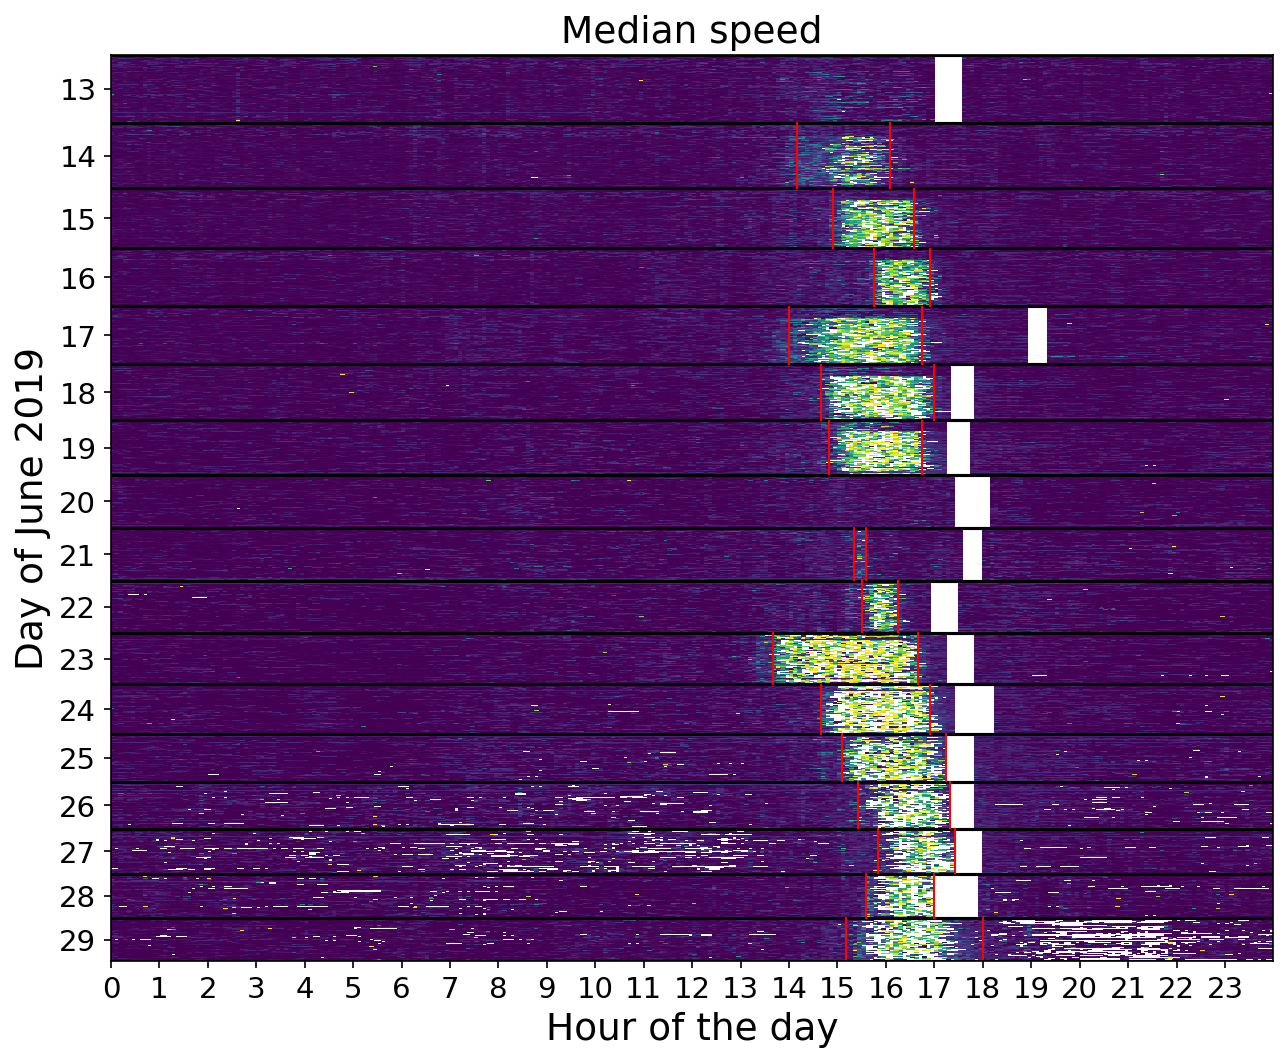

In [39]:
f,ax = plt.subplots(1,1,sharex=True,sharey='row')
f.set_size_inches(10,8)
a=ax
a.pcolormesh(np.vstack(alltoplot[::-1]), cmap='viridis',vmax=2,rasterized=True)
divisions = np.insert(np.cumsum(np.flip([x.shape[0] for x in alltoplot])),0,0)
[a.axhline(d,c='k') for d in divisions]
yticks = (divisions[1:]+divisions[:-1])/2
a.set_yticks(yticks)
a.set_yticklabels(np.flip(daynumstoshow)+junedaynumoffset)

a.set_xticks(np.arange(24)*12)
a.set_xticklabels(np.arange(24))
# title and labels
a.set_title('Median speed',fontsize=18)               
a.set_xlabel('Hour of the day',fontsize=18)
a.set_ylabel('Day of June 2019',fontsize=18)
a.tick_params(labelsize=14)

for i,act in enumerate(np.flipud(collectiveactivated)):
    ymin, ymax = (divisions[i]+1)/divisions[-1], (divisions[i+1]-1)/divisions[-1]
    a.axvline(act[0],c='r',ymin=ymin,ymax=ymax,linewidth=1)
    a.axvline(act[1]+1,c='r',ymin=ymin,ymax=ymax,linewidth=1)
a.set_xlim([0,numtimedivs])        
f.set_dpi(300)
# plt.savefig('image-output/raster300.pdf')
f.set_dpi(150)
# plt.savefig('image-output/raster150.pdf')
plt.show()

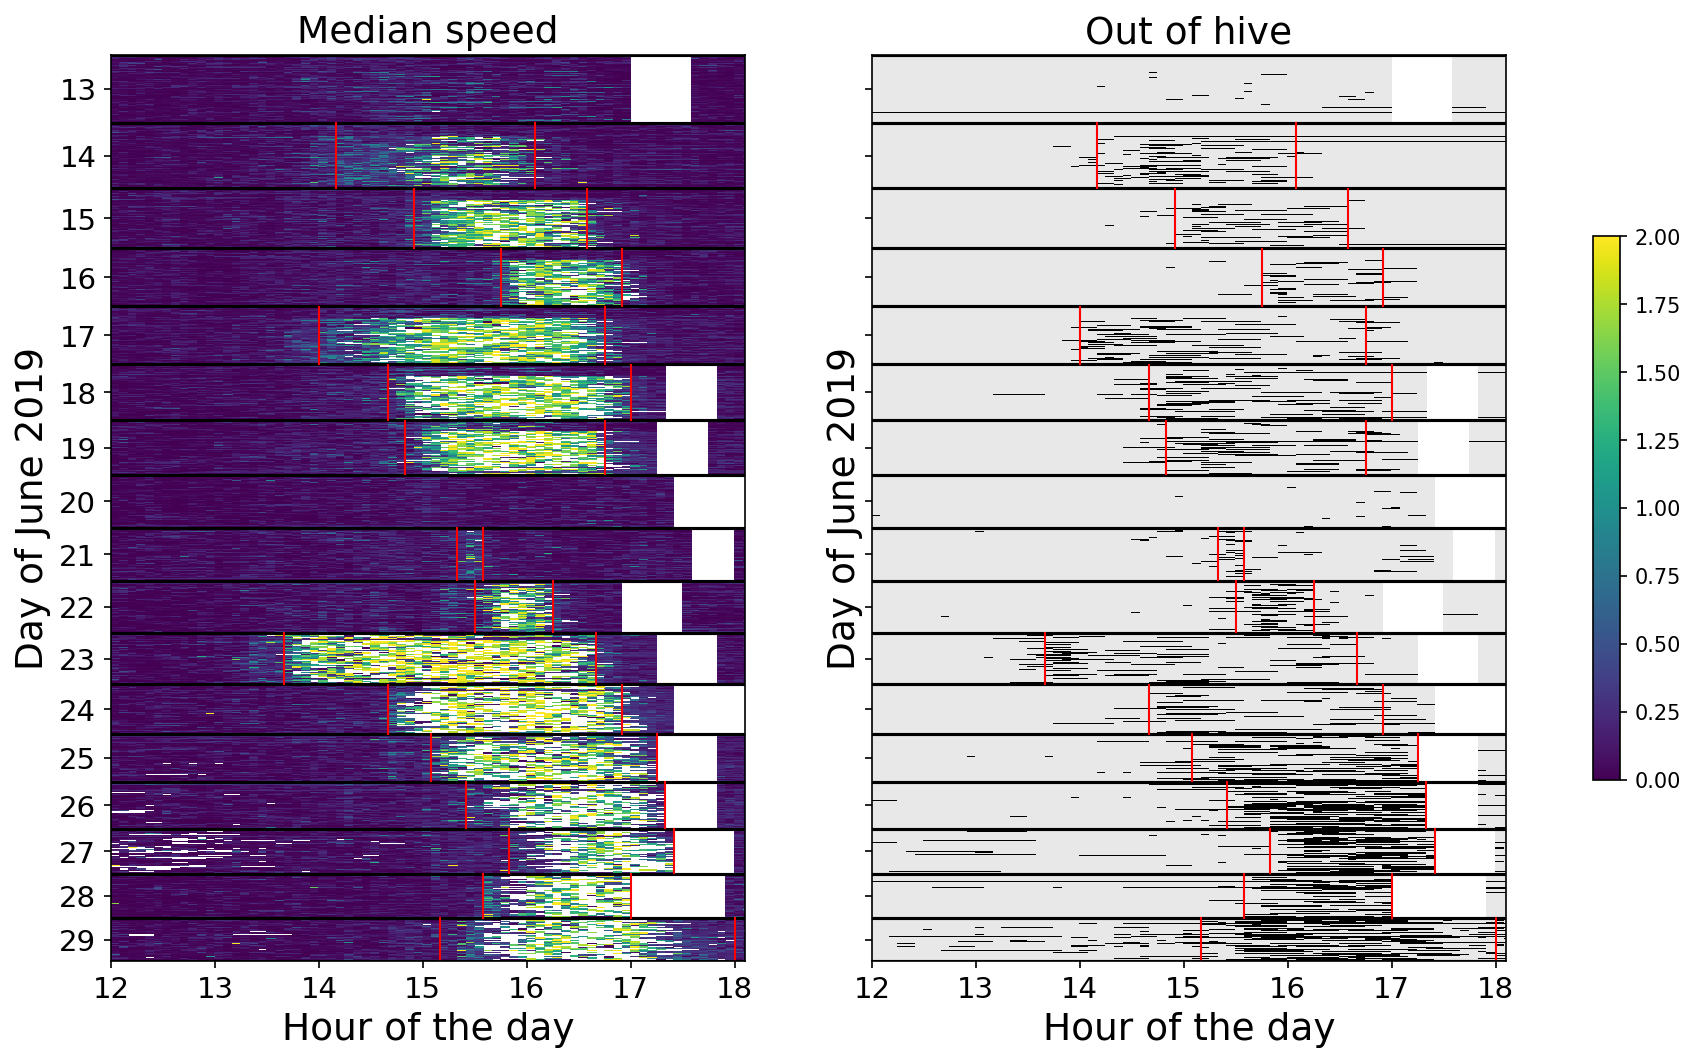

In [178]:
f,ax = plt.subplots(1,2,sharex=True,sharey='row')
f.set_size_inches(15,8)
a=ax[0]
pc = a.pcolormesh(np.vstack(alltoplot[::-1]), cmap='viridis',vmax=2,rasterized=True)
f.colorbar(pc, ax=ax,shrink=0.6)
a.set_title('Median speed',fontsize=18)

a=ax[1]
a.pcolormesh(np.vstack(alltoplotoutside[::-1]), cmap='binary',vmax=1,vmin=-0.1,rasterized=True)
a.set_title('Out of hive',fontsize=18)               

for a in ax:
    divisions = np.insert(np.cumsum(np.flip([x.shape[0] for x in alltoplot])),0,0)
    [a.axhline(d,c='k') for d in divisions]
    yticks = (divisions[1:]+divisions[:-1])/2
    a.set_yticks(yticks)
    a.set_yticklabels(np.flip(daynumstoshow)+junedaynumoffset)

    a.set_xticks(np.arange(24)*12)
    a.set_xticklabels(np.arange(24))
    # title and labels
    a.set_xlabel('Hour of the day',fontsize=18)
    a.set_ylabel('Day of June 2019',fontsize=18)
    a.tick_params(labelsize=14)
    a.set_xlim(np.array([12,18.1])*12)

    for i,act in enumerate(np.flipud(collectiveactivated)):
        ymin, ymax = (divisions[i]+1)/divisions[-1], (divisions[i+1]-1)/divisions[-1]
        a.axvline(act[0],c='r',ymin=ymin,ymax=ymax,linewidth=1)
        a.axvline(act[1]+1,c='r',ymin=ymin,ymax=ymax,linewidth=1)


# f.set_dpi(300)
# plt.savefig('image-output/raster300-focus.pdf')
### used this one for final figure, the colors are easier to see
f.set_dpi(150)
# plt.savefig('image-output/raster150-focus.pdf')
plt.show()

## B2 - Workers - Individuals (raster plot)

In [271]:
alltoplot = []
alltoplotoutside = []

for daynum in daynumstoshow:
    dfworkers = df[((df['Cohort ID']==7)|(df['Cohort ID']==9))&(df['Day number']==daynum)]
    # this doesnt work to show all
#     dfworkers = df[np.logical_not(((df['Cohort ID']==8)|(df['Cohort ID']==10))&(df['Day number']==daynum))]
    toplot_speed = dfworkers.pivot("Bee unique ID", 'timedivision', 'Median speed')
    alltoplot.append(toplot_speed)
    toplot_outside = dfworkers.pivot("Bee unique ID", 'timedivision', 'Out of hive')
    alltoplotoutside.append(toplot_outside)

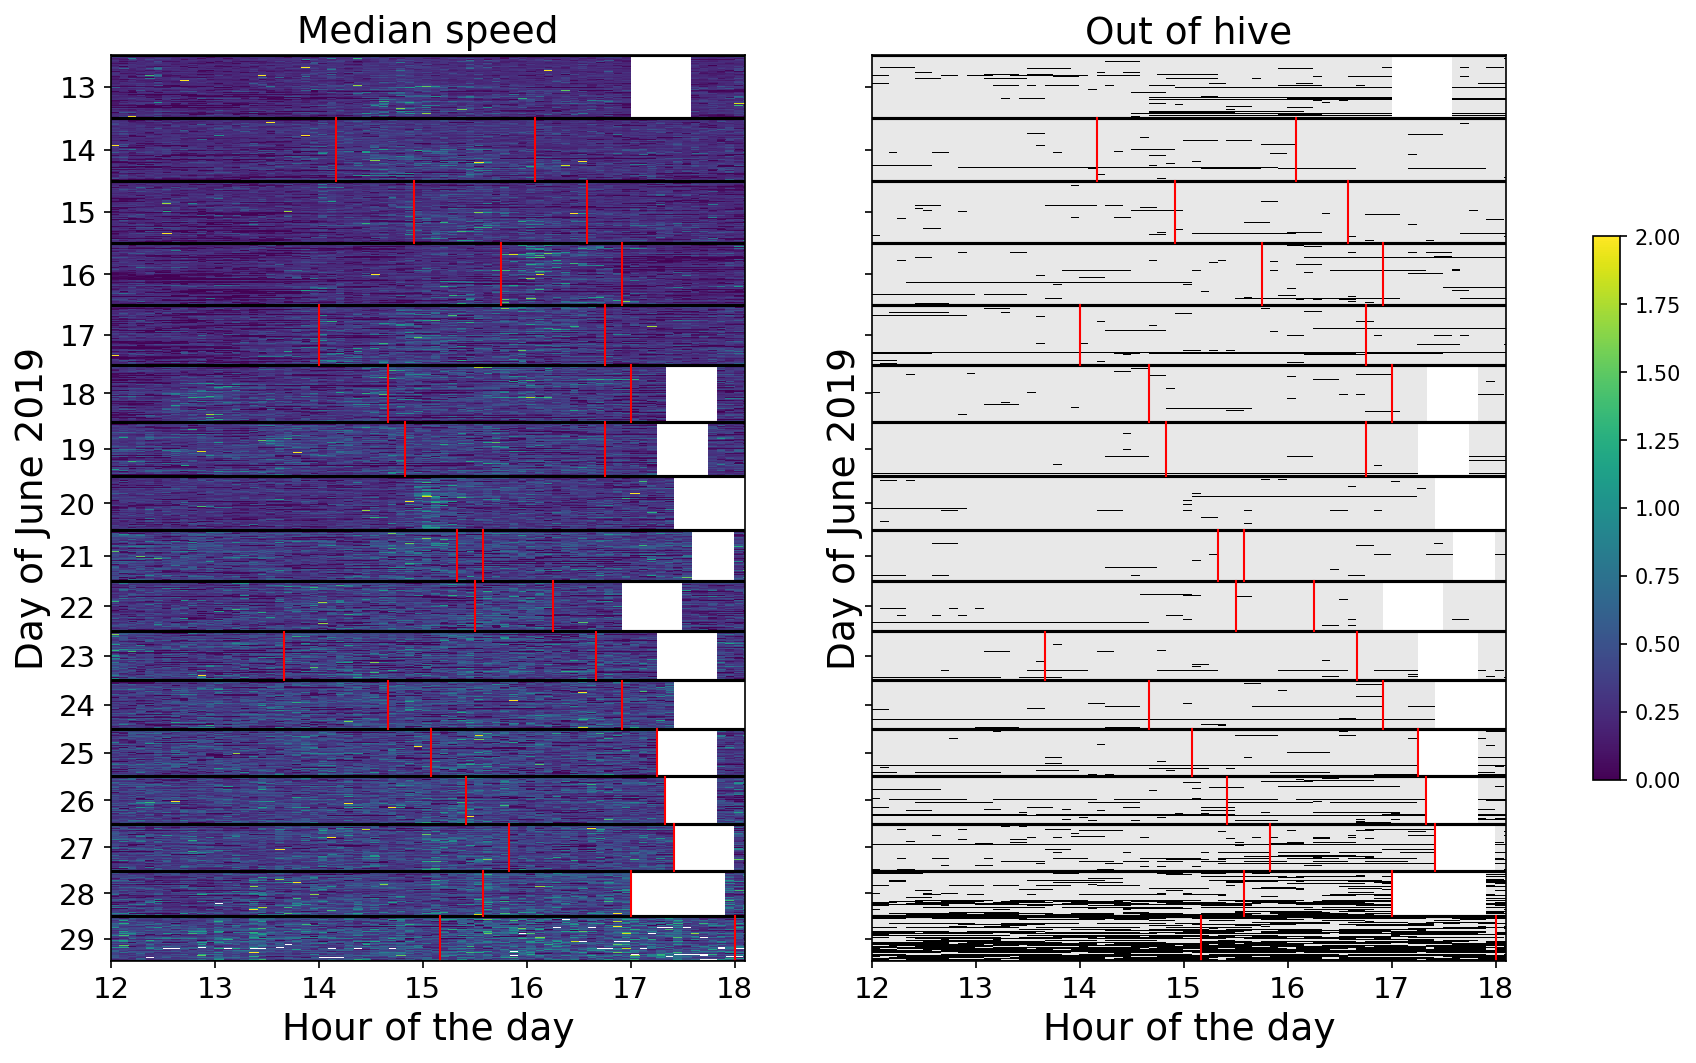

In [274]:
f,ax = plt.subplots(1,2,sharex=True,sharey='row')
f.set_size_inches(15,8)
a=ax[0]
pc = a.pcolormesh(np.vstack(alltoplot[::-1]), cmap='viridis',vmax=2,rasterized=True)
f.colorbar(pc, ax=ax,shrink=0.6)
a.set_title('Median speed',fontsize=18)

a=ax[1]
a.pcolormesh(np.vstack(alltoplotoutside[::-1]), cmap='binary',vmax=1,vmin=-0.1,rasterized=True)
a.set_title('Out of hive',fontsize=18)               

for a in ax:
    divisions = np.insert(np.cumsum(np.flip([x.shape[0] for x in alltoplot])),0,0)
    [a.axhline(d,c='k') for d in divisions]
    yticks = (divisions[1:]+divisions[:-1])/2
    a.set_yticks(yticks)
    a.set_yticklabels(np.flip(daynumstoshow)+junedaynumoffset)

    a.set_xticks(np.arange(24)*12)
    a.set_xticklabels(np.arange(24))
    # title and labels
    a.set_xlabel('Hour of the day',fontsize=18)
    a.set_ylabel('Day of June 2019',fontsize=18)
    a.tick_params(labelsize=14)
    a.set_xlim(np.array([12,18.1])*12)

    for i,act in enumerate(np.flipud(collectiveactivated)):
        ymin, ymax = (divisions[i]+1)/divisions[-1], (divisions[i+1]-1)/divisions[-1]
        a.axvline(act[0],c='r',ymin=ymin,ymax=ymax,linewidth=1)
        a.axvline(act[1]+1,c='r',ymin=ymin,ymax=ymax,linewidth=1)


f.set_dpi(150)
plt.savefig('image-output/raster150-focus-workers.pdf')
plt.show()

## C - Individuals - number of trips and duration of trip

In [179]:

all_trips_per_indiv = []
all_length_per_trip = []
i=1
for i in range(len(collectiveactivated)):
    act = collectiveactivated[i]
    indivdata = alltoplotoutside[i].values[:,act[0]:act[1]+1]

    diffs = np.diff(indivdata,axis=1)
    # trips per individual:  went outside (0 to 1) OR was outside at the start (started at 1)
    if act[0]>0:
        trips_per_indiv = np.sum(diffs==1,axis=1) + (indivdata[:,0]==1)
    else:
        trips_per_indiv = np.array([])
    # time per trip:
    # Special cases:
    ## start is 1:  then remove the first -1
    ## end is 1: then remove the last 1
    length_per_trip = [[]]
    if act[0]>0:
        for count, (indiv,d) in enumerate(zip(indivdata,diffs)):
            w_on = np.where(d==1)[0]
            w_off = np.where(d==-1)[0]
            if indiv[0]==1:
                w_off = w_off[1:]
            if indiv[-1]==1:
                w_on = w_on[0:-1]
            if not(len(w_on)==len(w_off)):
                print(count)
            if not(np.all(w_on<w_off)):
                print('oops',count)
            length_per_trip.append(w_off-w_on)
    all_trips_per_indiv.append(trips_per_indiv)
    all_length_per_trip.append(np.concatenate(length_per_trip))

/home/jdavidson/miniconda3/envs/bees2/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jdavidson/miniconda3/envs/bees2/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


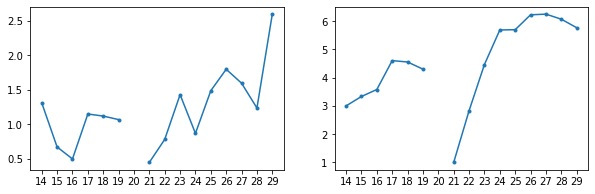

In [180]:
f,ax = plt.subplots(1,2,sharex=True)
f.set_size_inches(10,3)
tpx = daynumstoshow+junedaynumoffset
a=ax[0]
a.plot(tpx,[np.mean(x) for x in all_trips_per_indiv],marker='.')
a.set_xticks(tpx)
a=ax[1]
a.plot(tpx,[np.mean(x) for x in all_length_per_trip],marker='.')
plt.show()

Mean trips per indiv: 1.17 +/- 1.05
1.6802486187845305
Mean trip length (minutes): 24.2 +/- 11.6


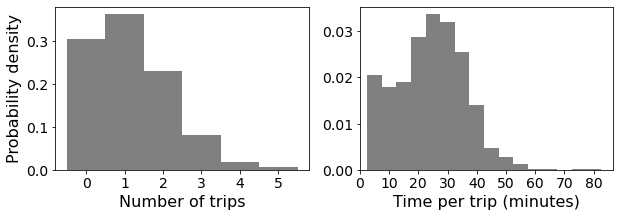

In [181]:
f,ax = plt.subplots(1,2)
f.set_size_inches(10,3)
a=ax[0]
tp = np.concatenate(all_trips_per_indiv)
print('Mean trips per indiv:',np.round(np.mean(tp),2),'+/-',np.round(np.std(tp),2))
print(np.mean(tp[tp>0]))
a.hist(tp,density=True,bins=np.arange(-0.5,np.max(tp)+1.5),color='grey')
a.set_xticks(np.arange(6))
a.set_xlabel('Number of trips',fontsize=16)
a=ax[1]
tp = np.concatenate(all_length_per_trip)
bins = np.arange(-0.5,np.max(tp)+1.5)
tp, bins = tp*5, bins*5  #convert timebins to minutes
print('Mean trip length (minutes):',np.round(np.mean(tp),1),'+/-',np.round(np.std(tp),1))
a.hist(tp,density=True,color='grey',bins=bins)
a.set_xticks(np.arange(0,90,10))
a.set_xlim(left=0)
a.set_xlabel('Time per trip (minutes)',fontsize=16)
ax[0].set_ylabel('Probability density',fontsize=16)
[a.tick_params(labelsize=14) for a in ax]
plt.savefig('image-output/numtrips-hists.pdf')
plt.show()

# (Fig 4) - Sankey/cluster order

## Activation order and correlation

In [171]:
all_indfirstacts = []
all_indfirstacts_speed = []
all_indfirstacts_outside = []
all_uids = []
for i,daynum in enumerate(daynumstoshow):
    actstart, actend = collectiveactivated[i]
    dayspeed = alltoplot[i].values
    dayout = alltoplotoutside[i].values

    backdivs=12

    indfirstacts = np.tile(-1,dayout.shape[0])
    indfirstacts_speed = np.tile(-1,dayout.shape[0])
    indfirstacts_outside = np.tile(-1,dayout.shape[0])    
    for j in range(len(dayout)):
        jact = np.where((dayspeed[j][actstart-backdivs:actend+1]>speedthreshold)|(dayout[j][actstart-backdivs:actend+1]==1))[0]
        jact_speed = np.where((dayspeed[j][actstart-backdivs:actend+1]>speedthreshold))[0]
        jact_outside = np.where((dayout[j][actstart-backdivs:actend+1]==1))[0]
        # if jact=0, then they activate at actstart-backdivs.  If jact=backdivs, then at the collective act time.
        # if jact>backdivs, then after the collective activation time.  The maximum is then backdivs+collective act time.
        if len(jact)>0:
            indfirstacts[j]=jact[0]
        if len(jact_speed)>0:
            indfirstacts_speed[j]=jact_speed[0]
        if len(jact_outside)>0:
            indfirstacts_outside[j]=jact_outside[0]            
    
    all_indfirstacts.append(indfirstacts)
    all_indfirstacts_speed.append(indfirstacts_speed)
    all_indfirstacts_outside.append(indfirstacts_outside)
    all_uids.append(alltoplot[i].index)


In [172]:
# -1 means was never activated on that day, nan means dead
dfact = pd.DataFrame(index=np.unique(np.concatenate(all_uids)))
for u,i,i_spd,i_out,daynum in zip(all_uids,all_indfirstacts,all_indfirstacts_speed,all_indfirstacts_outside,daynumstoshow):
    dfact.loc[u,daynum] = i
    dfact.loc[u,str(daynum)+'-spd'] = i_spd
    dfact.loc[u,str(daynum)+'-out'] = i_out

In [173]:
allcorr = np.tile(np.nan,len(daynumstoshow)-1)
for i,daynum in enumerate(daynumstoshow[:-1]):
    x,y = dfact[daynum],dfact[daynum+1]
    sel = (x>=0)&(y>=0)&np.logical_not(np.isnan(x))&np.logical_not(np.isnan(y))
    if np.sum(sel)>=2:
        corr = scipy.stats.pearsonr(x[sel],y[sel])[0]
    else:
        corr = np.nan
    print(i,daynum,corr)
    allcorr[i] = corr

0 8 nan
1 9 0.15204426577266617
2 10 0.10517847285413517
3 11 0.16346193563845715
4 12 0.3394266240187303
5 13 0.12394491381265962
6 14 nan
7 15 nan
8 16 0.09711654957296993
9 17 0.23425209380360573
10 18 0.2286148629974548
11 19 -0.0018711769905899733
12 20 0.1302923942933666
13 21 0.15447323821502282
14 22 0.2975371750854016
15 23 0.02027041460441515


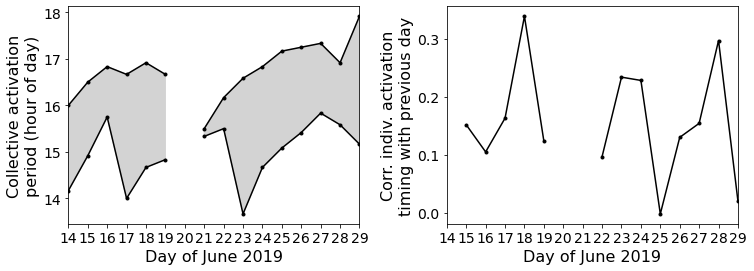

In [174]:
f,ax = plt.subplots(1,2)
f.set_size_inches(12,4)
a=ax[0]
tpx = daynumstoshow
tpy = np.array(collectiveactivated).copy().astype(float)/12
tpy[tpy<0] = np.nan
a.plot(tpx,tpy[:,0],c='k',marker='.')
a.plot(tpx,tpy[:,1],c='k',marker='.')
a.fill_between(tpx,tpy[:,0],tpy[:,1],alpha=1,color='lightgrey')
a.set_xticks(tpx)
a.set_xticklabels(tpx+junedaynumoffset)
a.set_ylabel('Collective activation\nperiod (hour of day)',fontsize=16)
a=ax[1]
tpx = daynumstoshow[:-1]+1
a.plot(tpx,allcorr,c='k',marker='.')
a.set_ylabel('Corr. indiv. activation\ntiming with previous day',fontsize=16)
a.set_xticks(tpx)
a.set_xticklabels(tpx+junedaynumoffset)

for a in ax:
    a.tick_params(labelsize=14)
    a.set_xlim([9,24])
    a.set_xlabel('Day of June 2019',fontsize=16)
    
plt.subplots_adjust(wspace=0.3)
plt.savefig('image-output/activation.pdf')
plt.show()



## Activation order relationship with other quantities

In [175]:
collectiveactivated

[[-1, -1],
 [170, 192],
 [179, 198],
 [189, 202],
 [168, 200],
 [176, 203],
 [178, 200],
 [-1, -1],
 [184, 186],
 [186, 194],
 [164, 199],
 [176, 202],
 [181, 206],
 [185, 207],
 [190, 208],
 [187, 203],
 [182, 215]]

In [176]:
divsperhour = 12
starttimediv, endtimediv = 0*divsperhour, 12*divsperhour

# add other metrics to dfact, so can compare them to the activation time
# keeping the morning period
i=2
metrics_tocompare = ['Exit distance (median)','Median speed']
all_dftocompare = []
for i, daynum in enumerate(daynumstoshow):
    uids = all_uids[i]
    # use both drone cohorts, because they are both included in activation order and correlation.  Just for def of "collective activation period" its selective
    dfdrones = df[((df['Cohort ID']==8)|(df['Cohort ID']==10))&(df['Day number']==daynum)]
    dfdrones = dfdrones[(dfdrones['timedivision']>=starttimediv)&(dfdrones['timedivision']<endtimediv)]  # just keep the "morning", for averaging

    gb = dfdrones.groupby('Bee unique ID')[metrics_tocompare].mean()
    gb = gb.merge(dfact[[daynum,str(daynum)+'-spd',str(daynum)+'-out']],left_on='Bee unique ID',right_on=dfact.index)
    gb.rename(columns={(daynum):'Relative Activation Time'},inplace=True)
    gb.rename(columns={str(daynum)+'-spd':'Relative Activation Time-Speed'},inplace=True)    
    gb.rename(columns={str(daynum)+'-out':'Relative Activation Time-Outside'},inplace=True)        
    # add ranked-order for each metric
    for m in metrics_tocompare:
        gb[m+'-order'] = np.argsort(np.argsort(gb[m]))
    all_dftocompare.append(gb)

In [177]:
# calculate and make per-day correlation plots
makecorrplots=False

metricpostfix = ['','-order'][1]  # use 1 or ordering
print('METRIC POSTFIX:',metricpostfix)

if makecorrplots:
    f,ax = plt.subplots(len(metrics_tocompare),len(daynumstoshow))
    f.set_size_inches(ax.shape[1]*4,ax.shape[0]*3)
corr_dm = np.tile(np.nan,(len(daynumstoshow),len(metrics_tocompare)))
for i,daynum in enumerate(daynumstoshow):
    for j,m in enumerate(metrics_tocompare):
        if makecorrplots:
            a=ax[j,i]
        x = all_dftocompare[i]['Relative Activation Time']
        y = all_dftocompare[i][m+metricpostfix]
        sel = (x>=0) & np.logical_not(np.isnan(y))
        if np.sum(sel)>2:
            corr = scipy.stats.pearsonr(x[sel],y[sel])[0]
            corr_dm[i,j] = corr
            if makecorrplots:
                sns.regplot(x=x[sel],y=y[sel],ax=a)
                a.set_title(np.round(corr,3),y=0.9)

METRIC POSTFIX: -order


Text(0.5, 1.03, 'Correlation values for each day')

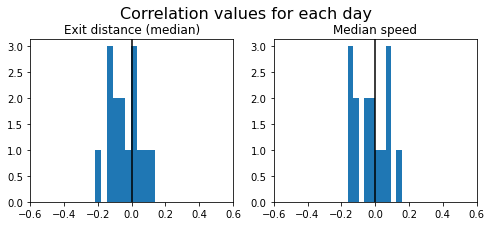

In [178]:
f,ax = plt.subplots(1,len(metrics_tocompare),sharex=True)
f.set_size_inches(len(ax)*4,3)
for j,m in enumerate(metrics_tocompare):
    a=ax[j]
    a.hist(corr_dm[:,j])
    a.set_title(m)
    a.axvline(0,c='k')
    a.set_xlim([-0.6,0.6])
plt.suptitle('Correlation values for each day',y=1.03,fontsize=16)

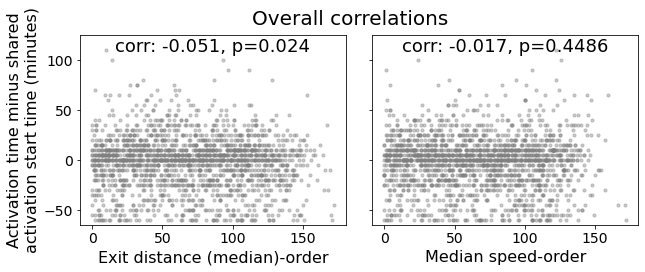

In [180]:
postfix = ''  # or '-Speed','-Outside', to look just at speed activation or going outside

f,ax = plt.subplots(1,len(metrics_tocompare),sharey=True)
f.set_size_inches(len(ax)*5,3.5)
for j,m in enumerate(metrics_tocompare):
    a=ax[j]
    tpx = np.array([])
    tpy = np.array([])
    for i,daynum in enumerate(daynumstoshow):
        x = all_dftocompare[i][m+metricpostfix]
        y = all_dftocompare[i]['Relative Activation Time'+postfix]        
        sel = (y>=0) & np.logical_not(np.isnan(x))
        tpx = np.concatenate((tpx,x[sel]))
        tpy = np.concatenate((tpy,y[sel]))

    corr, pvalue = scipy.stats.pearsonr(tpx,tpy)
    
    a.scatter(tpx,(tpy-backdivs)*5,alpha=0.4,s=10,c='grey',rasterized=True)
    a.set_title('corr: '+str(np.round(corr,3))+', p='+str(np.round(pvalue,4)),y=0.88,fontsize=18)
    a.set_xlabel(m+metricpostfix,fontsize=16)
    a.tick_params(labelsize=14)
    a.set_ylim([-65,125])
    # a.axhline(0,c='grey',label='Shared activation time')
ax[0].set_ylabel('Activation time minus shared\nactivation start time (minutes)',fontsize=16)    
plt.suptitle('Overall correlations'+postfix,fontsize=20)
plt.subplots_adjust(wspace=0.1)
plt.savefig('image-output/order-corr-metricsorder.pdf',dpi=600)
plt.show()

## Sankey plot, generalized

In [1108]:
# note: use this, NOT argsort! argsort doesn't actually give rank
# see this:  https://stackoverflow.com/questions/39059371/can-numpys-argsort-give-equal-element-the-same-rank
#  https://stackoverflow.com/questions/5284646/rank-items-in-an-array-using-python-numpy-without-sorting-array-twice
def getsortorder(x):
    return scipy.stats.rankdata(x,method='min')-1

In [1104]:
startdaynum=19
enddaynum=21
sankeynumdays = enddaynum-startdaynum+1
xlist = [dfact[i] for i in range(startdaynum,startdaynum+sankeynumdays)]

selact = np.all([(x>=0) for x in xlist],axis=0)
selalive = np.all([np.logical_not(np.isnan(x)) for x in xlist],axis=0) 
sel = selalive
xlist = [x[sel] for x in xlist]

In [1105]:
print('daynums:',startdaynum,'-',startdaynum+sankeynumdays-1)

daynums: 19 - 21


In [1109]:
dfpercentile = pd.DataFrame(index=xlist[0].index)
numbins=5
for i in range(len(xlist)):
    vals = xlist[i]
    numnonact = np.sum(vals==-1)
    binedges = np.linspace(numnonact,len(dfpercentile),numbins)
    binedges = np.insert(binedges,0,0)
    ordergroups = np.digitize(getsortorder(xlist[i]),binedges)
    # change 0 (no act) to be max
    ordergroups[ordergroups==0]=numbins
    ordergroups = ordergroups-1
    dfpercentile['x'+str(i)] = ordergroups

# don't use these order groups. It does not divide evenly, because collective activation is a simultaneous measure, and this is indiv
#     ordergroups = np.tile(np.nan,len(vals)) # default is the last group
#     ordergroups[(vals>=0)&(vals<=7)] = 0
#     ordergroups[(vals>=8)&(vals<=9)] = 1
#     ordergroups[(vals>=10)&(vals<=11)] = 2
#     ordergroups[vals>=12]=3
#     ordergroups[vals<0]=4
#     dfpercentile['x'+str(i)] = ordergroups.astype(int)
    

# count connections between each
allconn = np.zeros((sankeynumdays-1,numbins,numbins))
# loop through each bee, thats the easiest way to think about it
for u in dfpercentile.index:
    for i in range(sankeynumdays-1):
        v1,v2 = dfpercentile.loc[u,['x'+str(i),'x'+str(i+1)]].values - 1
        allconn[i,v1,v2]+=1
print('including this many drones: ',len(dfpercentile))

including this many drones:  124


In [1110]:

labels = np.tile(['Order Q1','Order Q2','Order Q3','Order Q4','No activ.'],sankeynumdays)
# labels = np.tile(['60-20 min PRE','20-10 min PRE','10-0 min PRE','POST','No activation'],sankeynumdays)

source = np.tile(np.arange(numbins),(numbins,1)).T
target = np.tile(np.arange(numbins),(numbins,1))
# labels = np.tile(['No activation','20-40%','40-60%','60-80%','80-100%'],sankeynumdays)


color_label=np.tile(['mediumblue','darkviolet','turquoise','green','hotpink'],sankeynumdays)

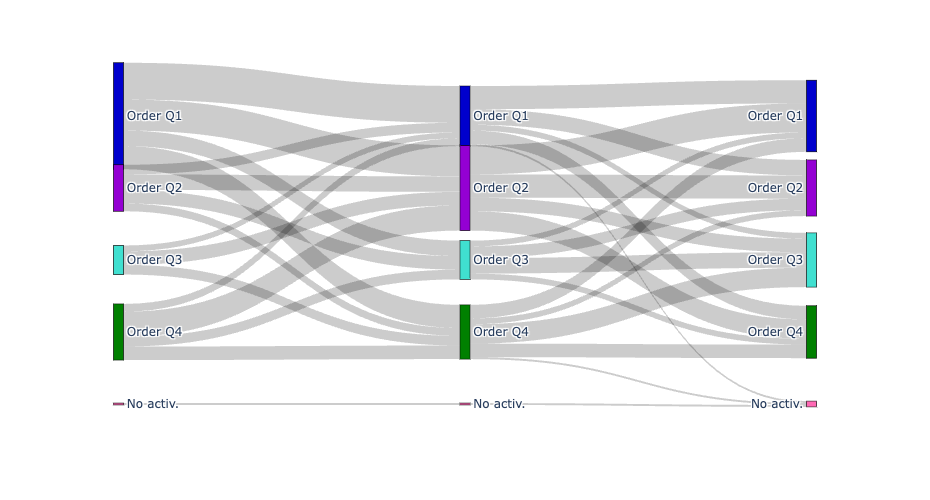

In [1111]:
xpos_offsets = np.linspace(0.05,0.95,sankeynumdays)
xpos = [np.tile(i,numbins) for i in xpos_offsets]

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 20,
      thickness = 10,
      line = dict(color = "black", width = 0.5),
      label = labels,
      color = color_label,
      y=np.tile(np.linspace(0.05,0.95,numbins),sankeynumdays),
      x=np.reshape(xpos,-1)
    ),
    arrangement='fixed',
    link = dict(
      source = np.reshape([source+i*numbins for i in range(sankeynumdays-1)],-1), # indices correspond to labels, eg A1, A2, A1, B1, ...
      target = np.reshape([target+i*numbins for i in range(1,sankeynumdays)],-1),
      value = np.reshape(allconn,-1)
  ))])
# fig.update_layout(title_text="", font_size=10)
layout = go.Layout(
    autosize=False,
    width=1000,
    height=500
)
fig.update_layout(layout)
fig.show()

In [230]:
fig.write_image("image-output/sankey_daynum"+str(startdaynum)+'-'+str(enddaynum)+".svg")

# (Fig 5) Weather comparison

In [45]:
weatherfile = 'weatherdata/MeteoBlue_LitzelStetten_weather_2019.xlsx'
weatherdataheader = pd.read_excel(weatherfile)[0:9]
pd.set_option('display.max_columns', None)
weatherdataheader

location                                      Litzelstetten  \
0          lat                                          47.694244   
1          lon                                           9.157275   
2          asl                                          407.72922   
3     variable                                        Temperature   
4         unit                                                 °C   
5        level                            2 m elevation corrected   
6   resolution                                             hourly   
7  aggregation                                               None   
8    timestamp  Litzelstetten Temperature [2 m elevation corre...   

                                     Litzelstetten.1  \
0                                          47.694244   
1                                           9.157275   
2                                          407.72922   
3                                Growing Degree Days   
4                                               GDDc   
5                            2 m elevation corrected   
6                                             hourly   
7                                               None   
8  Litzelstetten Growing Degree Days [2 m elevati...   

                       Litzelstetten.2                     Litzelstetten.3  \
0                            47.694244                           47.694244   
1                             9.157275                            9.157275   
2                            407.72922                           407.72922   
3                          Temperature                         Temperature   
4                                   °C                                  °C   
5                              1000 mb                              850 mb   
6                               hourly                              hourly   
7                                 None                                None   
8  Litzelstetten Temperature [1000 mb]  Litzelstetten Temperature [850 mb]   

                      Litzelstetten.4                  Litzelstetten.5  \
0                           47.694244                        47.694244   
1                            9.157275                         9.157275   
2                           407.72922                        407.72922   
3                         Temperature                Sunshine Duration   
4                                  °C                              min   
5                              700 mb                              sfc   
6                              hourly                           hourly   
7                                None                             None   
8  Litzelstetten Temperature [700 mb]  Litzelstetten Sunshine Duration   

                     Litzelstetten.6  \
0                          47.694244   
1                           9.157275   
2                          407.72922   
3                Shortwave Radiation   
4                               W/m²   
5                                sfc   
6                             hourly   
7                               None   
8  Litzelstetten Shortwave Radiation   

                            Litzelstetten.7  \
0                                 47.694244   
1                                  9.157275   
2                                 407.72922   
3                Direct Shortwave Radiation   
4                                      W/m²   
5                                       sfc   
6                                    hourly   
7                                      None   
8  Litzelstetten Direct Shortwave Radiation   

                             Litzelstetten.8  \
0                                  47.694244   
1                                   9.157275   
2                                  407.72922   
3                Diffuse Shortwave Radiation   
4                                       W/m²   
5                                        sfc   
6                       

In [46]:
pd.reset_option('max_columns')
weatherdata = pd.read_excel(weatherfile,header=9)

In [47]:
start = np.where(weatherdata['timestamp']==bd.alldaytimestamps[daystoload[0]])[0][0]
end = start+(len(daystoload)+1)*24
weather_per_hour = weatherdata[start:end][['Litzelstetten Temperature [2 m elevation corrected]','Litzelstetten Shortwave Radiation','Litzelstetten Vapor Pressure Deficit [2 m]']]

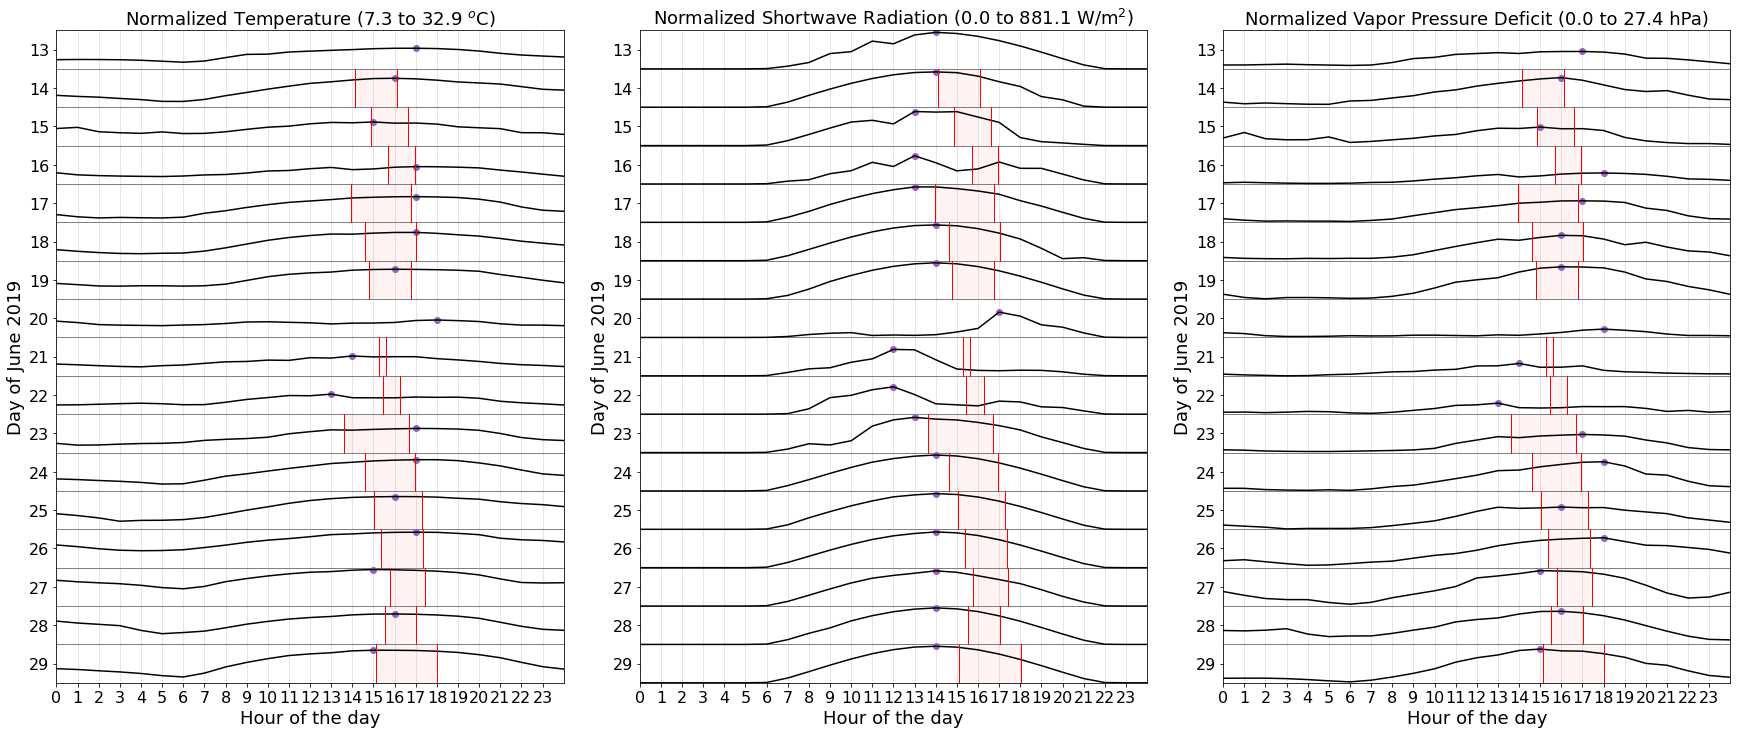

In [143]:

f,ax=plt.subplots(1,3,sharex=True,sharey=False)
f.set_size_inches(10*len(ax),12)
tpx = np.arange(0,24)

qnames = weather_per_hour.columns
titlelabels = ['Normalized Temperature','Normalized Shortwave Radiation','Normalized Vapor Pressure Deficit']
units = ['$^o$C','W/m$^2$','hPa']

maxhours = np.tile(np.nan,(len(titlelabels),len(daynumstoshow)))

for k, (titlelabel,qname) in enumerate(zip(titlelabels,qnames)):
    a=ax[k]
    y_perday = np.reshape(weather_per_hour[qname].values,(len(daystoload)+1,24))
    minval, maxval = np.min(y_perday), np.max(y_perday)
    title = titlelabel+' ('+str(np.round(minval,1))+' to '+str(np.round(maxval,1))+' '+units[k]+ ')'
    y_perday = (y_perday-minval)/(maxval-minval)

    yshift = 1.05
    yshifts=[]
    for ind,daynum in enumerate(daynumstoshow):
        i = np.where(daynum==daystoload)[0][0]
        offset=yshift*(24-i-1)
        yshifts.append(offset)
#         if k==0:
        a.axhline(offset,linewidth=1,zorder=-1,alpha=1,c='grey')
        a.plot(np.append(tpx,24),np.append(y_perday[i],y_perday[i+1,0])+offset,c='k')
        xmax = np.argmax(y_perday[i])
        a.scatter(xmax,y_perday[i][xmax]+offset,color=bp.snscolors[4])
        maxhours[k,ind] = xmax

    [a.axvline(j,c='grey',linewidth=1,zorder=-1,alpha=0.2) for j in range(24)]    
    a.set_xlim([0,24])
    a.tick_params(labelsize=16)
    a.set_xlim([0,24])
    #ticks
    a.set_xticks(np.arange(24))
    a.set_xticklabels(np.arange(24))
    a.set_yticks(np.array(yshifts)+yshift/2)
    a.set_yticklabels(daynumstoshow+junedaynumoffset)
    # title and labels
    a.set_title(title,fontsize=18)               
    a.set_xlabel('Hour of the day',fontsize=18)
    a.set_ylabel('Day of June 2019',fontsize=18)

    yshifts = np.insert((yshifts),0,yshifts[0]+yshift)
    a.set_ylim([yshifts[-1],yshifts[0]])
    for i,act in enumerate(np.array(collectiveactivated)):
        ymax, ymin = (yshifts[i])/yshifts[0], (yshifts[i+1])/yshifts[0]
        act = act/(numtimedivs)*24*287/288  # looks reasonable, I didn't do the linspace the most exact way though
        if act[0]>0:
            a.axvline(act[0],c='r',ymin=ymin,ymax=ymax,linewidth=1)
            a.axvline(act[1]+2/12,c='r',ymin=ymin,ymax=ymax,linewidth=1)    
            a.axvspan(act[0],act[1]+2/12,color='r',alpha=0.05,zorder=-1,ymin=ymin,ymax=ymax)

            
plt.subplots_adjust(wspace=0.15)
plt.savefig('image-output/weather-hourly.pdf')
plt.show()

In [144]:
# take per-day averages to use below
start = np.where(weatherdata['timestamp']==bd.alldaytimestamps[daystoload[0]])[0][0]
end = start+(len(daystoload)+1)*24
qnamestoaverage = ['Litzelstetten Mean Sea Level Pressure [MSL]', 'Litzelstetten Vapor Pressure Deficit [2 m]']
weather_per_hour_averaged = [np.mean(np.reshape(weatherdata[start:end][[q]].values,(len(daystoload)+1,24)),axis=1) for q in qnamestoaverage]


## Other weather data
From this site, can download the open sources of weather data
https://meteostat.net/de/
It says that "per-hour" data is available for Konstanz, but in the online download interface, when choosing 2019, it only downloads per-day. (For recent times, e.g. last week, it downloads per-hour). Probably there is some way through the API to get the per-hour data but I didn't figure it out

In [145]:
meteobluedaily = pd.read_excel('weatherdata/MeteoBlue_Daily_June2019_Litzelstetten.xlsx',header=9)
meteobluedaily.head()

/home/jdavidson/miniconda3/envs/bees2/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


timestamp  Konstanz-Litzelstetten Temperature [2 m elevation corrected]  \
0 2019-06-01                                          24.869740              
1 2019-06-02                                          25.419739              
2 2019-06-03                                          27.759739              
3 2019-06-04                                          27.809738              
4 2019-06-05                                          28.259739              

   Konstanz-Litzelstetten Temperature [2 m elevation corrected].1  \
0                                           10.79974                
1                                           12.89974                
2                                           14.29974                
3                                           14.34974                
4                                           11.85974                

   Konstanz-Litzelstetten Temperature [2 m elevation corrected].2  \
0                                          18.511406                
1                                          19.326822                
2                                          20.025572                
3                                          20.918074                
4                                          20.483072                

   Konstanz-Litzelstetten Sunshine Duration  \
0                                 924.95680   
1                                 948.78330   
2                                 747.14996   
3                                 941.74750   
4                                 884.86880   

   Konstanz-Litzelstetten Shortwave Radiation  \
0                                   7986.8590   
1                                   8220.9300   
2                                   7591.6997   
3                                   8125.7000   
4                                   7890.7393   

   Konstanz-Litzelstetten Precipitation Total  \
0                                         0.0   
1                                         0.0   
2                                         0.0   
3                                         0.0   
4                                         0.1   

   Konstanz-Litzelstetten Cloud Cover Total  \
0                                  1.454166   
1                                  0.475000   
2                                 15.950000   
3                                 21.666666   
4                                  4.708334   

   Konstanz-Litzelstetten Cloud Cover High [high cld lay]  \
0                                           4.291666        
1                                           1.583333        
2                                          13.333333        
3                                          16.875000        
4                                           0.250000        

   Konstanz-Litzelstetten Cloud Cover Medium [mid cld lay]  \
0                                           0.000000         
1                                           0.000000         
2                                          14.541667         
3                                          21.666666         
4                                           4.708334         

   Konstanz-Litzelstetten Cloud Cover Low [low cld lay]  \
0                                           0.416667      
1                                           0.000000      
2                                          10.416667      
3                                           4.375000      
4                                           0.000000      

   Konstanz-Litzelstetten CAPE [180-0 mb above gnd]  \
0                                             217.0   
1                                             687.0   
2                                            1917.0   
3                                            1247.0   
4                                            1654.0   

   Konstanz-Litzelstetten CAPE [180-0 mb above gnd].1  \
0                                                0.0    
1       

In [146]:
weathernames = ['Konstanz','Singen','Stochach','Guttingen','Friedrichshafen-Unterraderach']
openweatherdata = [pd.read_excel('weatherdata/OpenDWD_Daily_June2019_'+w+'.xlsx') for w in weathernames]
weathernames_label = ['DWD-'+n for n in weathernames]
openweatherdata[0].head()

date  tavg  tmin  tmax  prcp  snow  wdir  wspd  wpgt    pres  tsun
0  2019-06-01  19.9  11.8  27.7   0.0   NaN    22   5.4  16.6  1021.2   904
1  2019-06-02  21.1  12.9  29.0   0.0   NaN    41   5.8  16.2  1016.9   907
2  2019-06-03  21.4  14.1  30.6   0.0   NaN    19   6.8  60.8  1014.9   821
3  2019-06-04  23.2  15.6  31.3   0.0   NaN    77   5.8  16.6  1010.1   866
4  2019-06-05  24.0  16.7  31.3   0.0   NaN    69   7.6  52.6  1004.9   788

In [147]:
bd.alldaytimestamps[1]

Timestamp('2019-06-06 00:00:00', freq='D')

In [148]:
startind = 5
[o['date'][startind] for o in openweatherdata]

['2019-06-06', '2019-06-06', '2019-06-06', '2019-06-06', '2019-06-06']

In [149]:
# make tsun have units of hours instead
meteobluedaily['Konstanz-Litzelstetten Sunshine Duration'] = meteobluedaily['Konstanz-Litzelstetten Sunshine Duration']/60
for o in openweatherdata:
    o['tsun'] = o['tsun']/60

In [150]:
# add the averaged quantites abover to the meteobluedaily df
for q,w in zip(qnamestoaverage,weather_per_hour_averaged):
    meteobluedaily.loc[startind:,q] = w

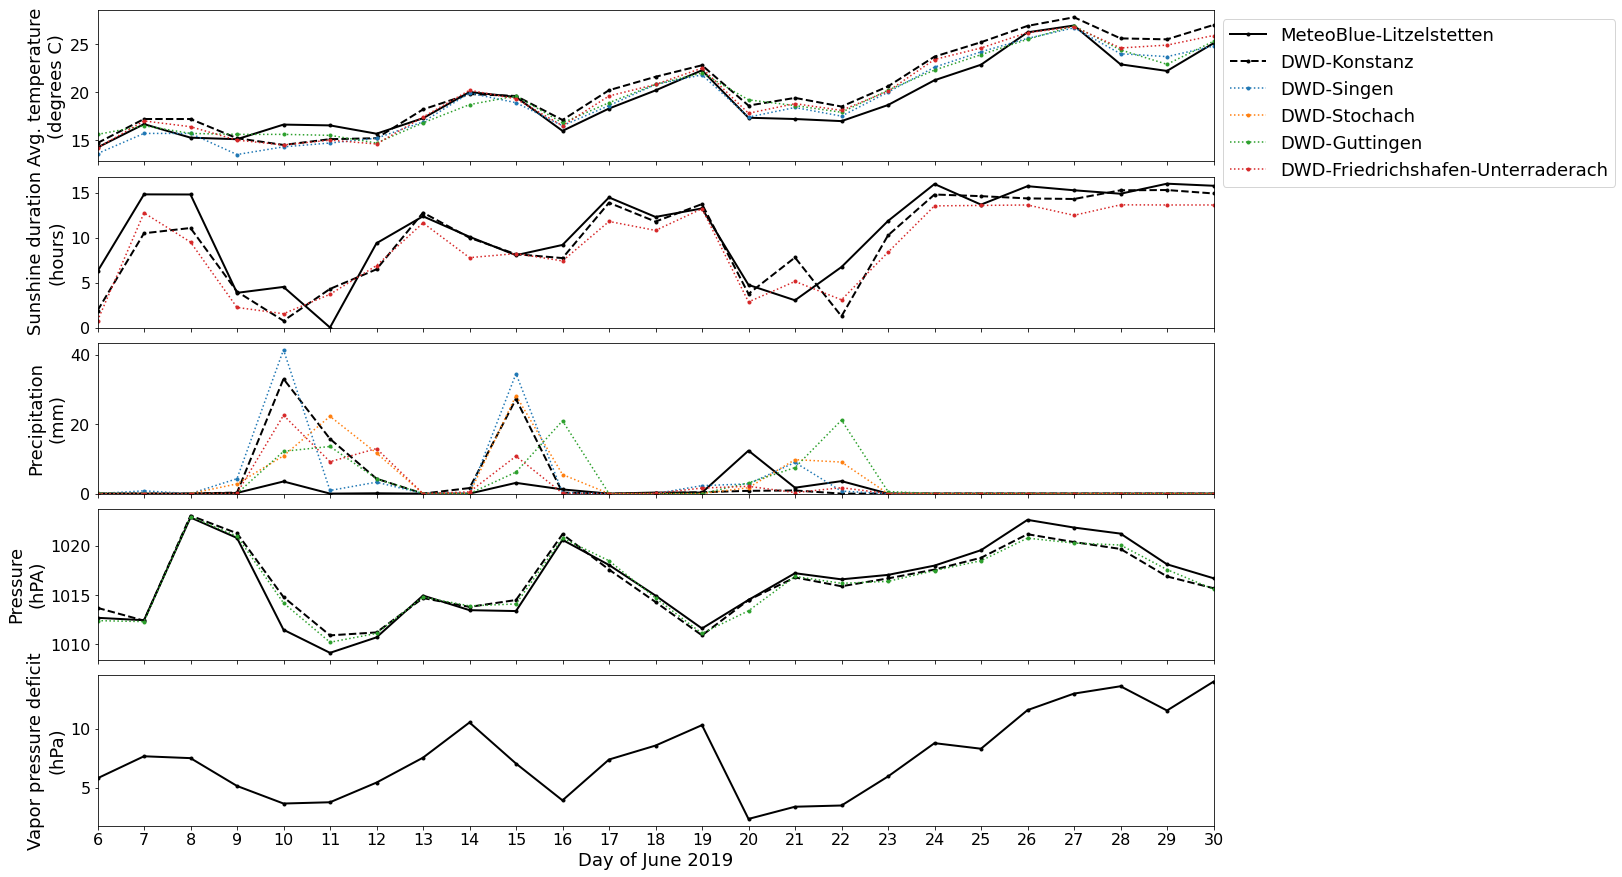

In [151]:
meteonames = ['Konstanz-Litzelstetten Temperature [2 m elevation corrected].2','Konstanz-Litzelstetten Sunshine Duration','Konstanz-Litzelstetten Precipitation Total'] + [qnamestoaverage[0]]
dwdnames = ['tavg','tsun','prcp','pres']
ylabels = ['Avg. temperature\n(degrees C)','Sunshine duration\n(hours)','Precipitation\n(mm)','Pressure\n(hPA)',]

f,ax = plt.subplots(5,1,sharex=True)
f.set_size_inches(20,3*len(ax))
tpx = np.arange(25)

for a, n, mn,ylabel in zip(ax,dwdnames,meteonames,ylabels):
    a.plot(tpx,meteobluedaily[mn][startind:startind+len(tpx)],c='k',linestyle='-',label='MeteoBlue-Litzelstetten',marker='.',linewidth=2)
    for i, (wname,data) in enumerate(zip(weathernames_label,openweatherdata)):
        tpy = data[n][startind:startind+len(tpx)]
        a.plot(tpx,tpy,marker='.',label=wname,c=('k' if i==0 else bp.snscolors[i-1]),linestyle=('--' if i==0 else ':'),linewidth=(2 if i==0 else 1.5))
    a.set_ylabel(ylabel,fontsize=18)

# plot VPD separate because its only for MeteoBlue:
a=ax[-1]
a.plot(tpx,meteobluedaily[qnamestoaverage[1]][startind:startind+len(tpx)],c='k',linestyle='-',label='MeteoBlue-Litzelstetten',marker='.',linewidth=2)
a.set_ylabel('Vapor pressure deficit\n(hPa)',fontsize=18)

for a in ax:
    a.tick_params(labelsize=16)
    a.set_xticks(tpx)
ax[-1].set_xticklabels(tpx+junedaynumoffset+1)  # setting this so that the first day is the day shown above 
ax[0].legend(fontsize=18,bbox_to_anchor=[1,1])
ax[0].set_xlim([0,24])
ax[-1].set_xlabel('Day of June 2019',fontsize=18)
plt.subplots_adjust(hspace=0.1)
ax[1].set_ylim(bottom=0)
ax[2].set_ylim(bottom=0)
plt.savefig('image-output/weather-daily.pdf')
plt.show()

## Weather comparison with collective activation

In [152]:
bd.alldaytimestamps[daynumstoshow[0]]

Timestamp('2019-06-13 00:00:00', freq='D')

In [153]:
startind = 12
meteobluedaily['timestamp'][startind]

Timestamp('2019-06-13 00:00:00')

In [154]:
mb_tocompare = meteobluedaily[startind:startind+len(daynumstoshow)]
mb_tocompare

timestamp  Konstanz-Litzelstetten Temperature [2 m elevation corrected]  \
12 2019-06-13                                          21.769740              
13 2019-06-14                                          27.609740              
14 2019-06-15                                          23.879740              
15 2019-06-16                                          19.469740              
16 2019-06-17                                          25.329739              
17 2019-06-18                                          27.169739              
18 2019-06-19                                          28.219740              
19 2019-06-20                                          19.539740              
20 2019-06-21                                          21.229738              
21 2019-06-22                                          21.379740              
22 2019-06-23                                          24.239738              
23 2019-06-24                                          29.219740              
24 2019-06-25                                          30.279740              
25 2019-06-26                                          32.199740              
26 2019-06-27                                          32.939740              
27 2019-06-28                                          28.679739              
28 2019-06-29                                          30.149738              

    Konstanz-Litzelstetten Temperature [2 m elevation corrected].1  \
12                                          11.949740                
13                                          11.359740                
14                                          15.749740                
15                                          12.519740                
16                                          10.389740                
17                                          12.229740                
18                                          16.369740                
19                                          15.589740                
20                                          13.599740                
21                                          13.819740                
22                                          12.499740                
23                                          12.129740                
24                                          12.959740                
25                                          19.209740                
26                                          19.419739                
27                                          14.839740                
28                                          11.399740                

    Konstanz-Litzelstetten Temperature [2 m elevation corrected].2  \
12                                          17.281824                
13                                          20.012240                
14                                          19.499740                
15                                          15.965571                
16                                          18.292238                
17                                          20.180157                
18                                          22.276405                
19                                          17.333490                
20                                          17.200160                
21                                          16.981405                
22                                          18.656408                
23                                          21.240156                
24                                          22.854738                
25                                          26.230990                
26                                          26.940987                
27                                          22.896406                
28                                          22.207657                

    Konstanz-Litzelstetten Sunshine Duration  \
12         

In [155]:
bd.alldaytimestamps[daynumstoshow]

DatetimeIndex(['2019-06-13', '2019-06-14', '2019-06-15', '2019-06-16',
               '2019-06-17', '2019-06-18', '2019-06-19', '2019-06-20',
               '2019-06-21', '2019-06-22', '2019-06-23', '2019-06-24',
               '2019-06-25', '2019-06-26', '2019-06-27', '2019-06-28',
               '2019-06-29'],
              dtype='datetime64[ns]', freq=None)

In [156]:
collactstarts = np.tile(np.nan,len(daynumstoshow))
collactdurations = np.tile(np.nan,len(daynumstoshow))
for i,act in enumerate(collectiveactivated):
    if act[0]>0:
        collactstarts[i] = act[0]*5/60  # assuming 5 minute divisions
        collactdurations[i] = (act[1]+1-act[0])*5/60 # include the end period

In [167]:
print('shared activation period duration, in minutes')
pd.DataFrame(([bd.alldaytimestamps[daynumstoshow],collactdurations*60]))

shared activation period duration, in minutes


0                    1                    2                    3   \
0 2019-06-13  2019-06-14 00:00:00  2019-06-15 00:00:00  2019-06-16 00:00:00   
1        NaT                115.0                100.0                 70.0   

                    4                    5                    6          7   \
0  2019-06-17 00:00:00  2019-06-18 00:00:00  2019-06-19 00:00:00 2019-06-20   
1                165.0                140.0                115.0        NaT   

                    8                    9                    10  \
0  2019-06-21 00:00:00  2019-06-22 00:00:00  2019-06-23 00:00:00   
1                 15.0                 45.0                180.0   

                    11                   12                   13  \
0  2019-06-24 00:00:00  2019-06-25 00:00:00  2019-06-26 00:00:00   
1                135.0                130.0                115.0   

                    14                   15                   16  
0  2019-06-27 00:00:00  2019-06-28 00:00:00  2019-06-29 00:00:00  
1                 95.0                 85.0                170.0

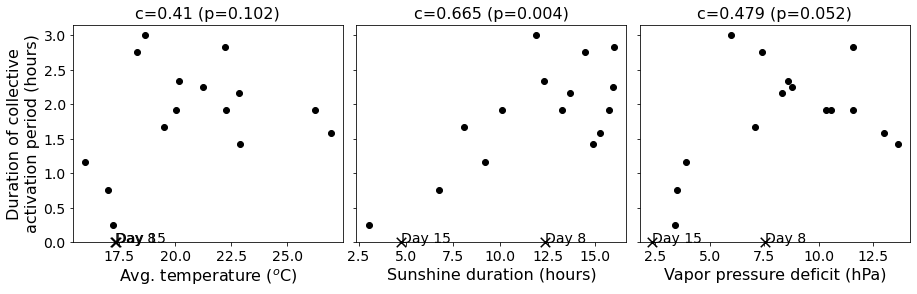

In [157]:
meteonames = ['Konstanz-Litzelstetten Temperature [2 m elevation corrected].2','Konstanz-Litzelstetten Sunshine Duration'] + [qnamestoaverage[-1]]

xlabels = ['Avg. temperature ($^o$C)','Sunshine duration (hours)','Vapor pressure deficit (hPa)']

f,ax = plt.subplots(1,3,sharey=True)
f.set_size_inches(5*len(ax),4)

noact = np.isnan(collactdurations)
noactdaynums = daynumstoshow[noact]


for j,m in enumerate(meteonames):
    a=ax[j]
    xtp = mb_tocompare[m]
    forcorr = collactdurations.copy()
    a.scatter(xtp,forcorr,c='k')
    forcorr[np.isnan(forcorr)] = 0
    corr, pvalue = scipy.stats.pearsonr(xtp,forcorr)
    a.set_title('c='+str(np.round(corr,3))+' (p='+str(np.round(pvalue,3))+')',fontsize=16)
    tpnoact=xtp[noact]
    a.scatter(tpnoact,np.zeros(np.sum(noact)),marker='x',s=90,c='k',clip_on=False)
    for i,x in enumerate(tpnoact):
        a.annotate('Day '+str(noactdaynums[i]), (x, 0),fontsize=14)
    a.set_xlabel(xlabels[j],fontsize=16)
ax[0].set_ylabel('Duration of collective\nactivation period (hours)',fontsize=16)

# # plt openDWD KN separate
# a=ax[-1]
# wind=0
# tp = openweatherdata[wind]['prcp'][startind:startind+len(daynumstoshow)]
# a.scatter(tp,collactdurations,c='k')
# a.scatter(tp[noact],np.zeros(np.sum(noact)),marker='x',s=90,c='k',clip_on=False)
# for i,x in enumerate(tp[noact]):
#     a.annotate('Day '+str(noactdaynums[i]), (x, 0),fontsize=14)
# a.set_xlabel('Precipitation-Konstanz (mm)',fontsize=16)

for a in ax:
    a.tick_params(labelsize=14)
    a.set_ylim(bottom=0)
plt.subplots_adjust(wspace=0.05)
plt.savefig('image-output/weathercorr.pdf')
plt.show()

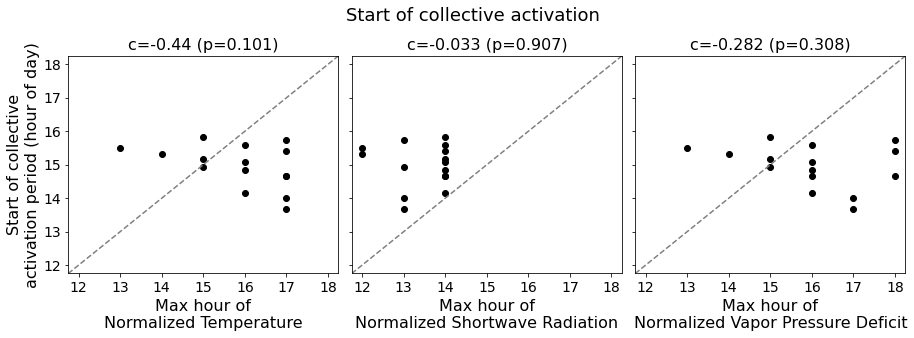

In [158]:
## Start of collective activation with peak times
meteonames = ['Konstanz-Litzelstetten Temperature [2 m elevation corrected].2','Konstanz-Litzelstetten Sunshine Duration'] + [qnamestoaverage[-1]]

xlabels = ['Avg. temperature ($^o$C)','Sunshine duration (hours)','Vapor pressure deficit (hPa)']

f,ax = plt.subplots(1,3,sharey=True,sharex=True)
f.set_size_inches(5*len(ax),4)

noact = np.isnan(collactdurations)
noactdaynums = daynumstoshow[noact]


for j,m in enumerate(titlelabels):
    a=ax[j]
    xtp = maxhours[j]
    forcorr = collactstarts.copy()
    a.scatter(xtp,forcorr,c='k')
#     sns.regplot(xtp,forcorr,ax=a)
    corr, pvalue = scipy.stats.pearsonr(xtp[~noact],forcorr[~noact])
    a.set_title('c='+str(np.round(corr,3))+' (p='+str(np.round(pvalue,3))+')',fontsize=16)
#     tpnoact=xtp[noact]
#     a.scatter(tpnoact,np.zeros(np.sum(noact)),marker='x',s=90,c='k',clip_on=False)
#     for i,x in enumerate(tpnoact):
#         a.annotate('Day '+str(noactdaynums[i]), (x, 0),fontsize=14)
    a.set_xlabel('Max hour of\n'+m,fontsize=16)
ax[0].set_ylabel('Start of collective\nactivation period (hour of day)',fontsize=16)

for a in ax:
    a.tick_params(labelsize=14)
#     a.set_ylim(bottom=0)
    a.set_xlim([11.75,18.25])
    a.set_ylim([11.75,18.25])
    a.set_xticks(np.arange(12,19))
    a.set_yticks(np.arange(12,19))    
    x=np.arange(11,20)
    a.plot(x,x,c='grey',linestyle='--')
plt.subplots_adjust(wspace=0.05)
plt.suptitle('Start of collective activation',fontsize=18,y=1.05)
plt.savefig('image-output/weathercorr-start.pdf')
plt.show()

# (Fig 6): activate non-drone bees?

In [246]:
df.columns

Index(['Age', 'Num. observations', 'Honey', 'Brood care', 'Pollen',
       'Dance floor', 'Other', 'Frame 0', 'Frame 1', 'Frame 2', 'Frame 3',
       'Frame 4', 'Frame 5', 'Median speed', 'Speed IQR',
       'Speed 90th quantile', 'Dispersion (avg)', 'Exit distance (median)',
       'Fraction squares visited', 'Day number', 'Festoon', 'Empty comb',
       'blank1', 'blank2', 'Bee unique ID', 'Cohort ID', 'Num. outside trips',
       'Num. dance floor visits', 'Dispersion-minute avg.',
       'Frame 0 - Num. crossings', 'Frame 1 - Num. crossings',
       'Frame 2 - Num. crossings', 'Frame 3 - Num. crossings',
       'Frame 4 - Num. crossings', 'Frame 5 - Num. crossings', 'timedivision',
       'Out of hive'],
      dtype='object')

In [247]:
colnums = [np.where(df.columns=='Median speed')[0][0]] #,np.where(df.columns=='Dispersion (avg)')[0][0]]
colnums

[13]

In [248]:
obs_threshold=10 / (3*60*5) # I had converted to fraction of 5 min period fully tracked, so make this instead.  This is very low
substratefrac_threshold=0.5
substratename='Frame 5'

toplotaveragevalues = np.tile(np.nan,(len(colnums),len(daynumstoshow),numtimedivs))
for i,daynum in enumerate(daynumstoshow):
    dfday = df[(df['Day number']==daynum)&np.logical_not((df['Cohort ID']==8)|(df['Cohort ID']==10))]
    day_uids, day_ages, all_onsubstrate, bee_obs, bee_data = dfunc.get_onsubstrate(dfday, obs_threshold, substratefrac_threshold, substratename=substratename,numtimedivs=numtimedivs)

    for k,colnum in enumerate(colnums):
        to_average = bee_data[:,:,colnum]
        to_average[all_onsubstrate==0] = np.nan
        to_average[bee_obs<obs_threshold] = np.nan        
        toplotaveragevalues[k,i] = np.nanmean(to_average,axis=0)

    # toplotaveragevalues.append(np.nanmean(to_average,axis=0))

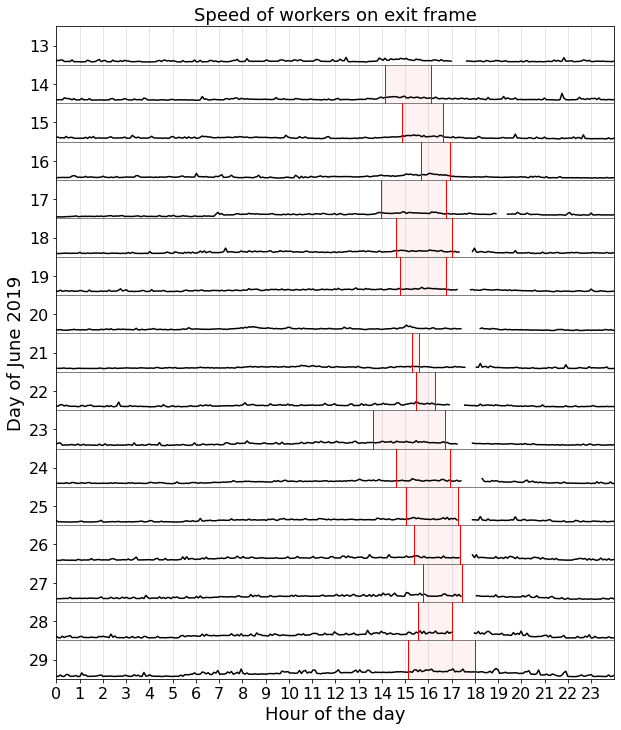

In [249]:

f,ax=plt.subplots(1,1,sharex=True,sharey=False)
f.set_size_inches(10*len(colnums),12)

tpx = np.linspace(0,24,numtimedivs)

# for k in range(len(colnums)):
k=0
a=ax
y_perday = np.array(toplotaveragevalues[k].copy())
# don't normalized like the weather data - set explicit values
#     minval, maxval = np.nanmin(y_perday), np.nanmax(y_perday)
#     title = titlelabel+' ('+str(np.round(minval,1))+' to '+str(np.round(maxval,1))+' '+units[k]+ ')'
#     y_perday = (y_perday-minval)/(maxval-minval)

yshift = [2.5,7][k] #1.05
yshifts=[]
for i,daynum in enumerate(daynumstoshow):
    offset=yshift*(len(daynumstoshow)-i-1)
    yshifts.append(offset)
#         if k==0:
    a.axhline(offset,linewidth=1,zorder=-1,alpha=1,c='grey')
    a.plot(tpx,y_perday[i]+offset,c='k')


[a.axvline(j,c='grey',linewidth=1,zorder=-1,alpha=0.2) for j in range(24)]    
a.set_xlim([0,24])
a.tick_params(labelsize=16)
a.set_xlim([0,24])
#ticks
a.set_xticks(np.arange(24))
a.set_xticklabels(np.arange(24))
a.set_yticks(np.array(yshifts)+yshift/2)
a.set_yticklabels(daynumstoshow+junedaynumoffset)
# title and labels
a.set_xlabel('Hour of the day',fontsize=18)
a.set_ylabel('Day of June 2019',fontsize=18)

yshifts = np.insert((yshifts),0,yshifts[0]+yshift)
a.set_ylim([yshifts[-1],yshifts[0]])
for i,act in enumerate(np.array(collectiveactivated)):
    ymax, ymin = (yshifts[i])/yshifts[0], (yshifts[i+1])/yshifts[0]
    act = act/(numtimedivs)*24*287/288  # looks reasonable, I didn't do the linspace the most exact way though
    if act[0]>0:
        a.axvline(act[0],c='r',ymin=ymin,ymax=ymax,linewidth=1)
        a.axvline(act[1]+2/12,c='r',ymin=ymin,ymax=ymax,linewidth=1)    
        a.axvspan(act[0],act[1]+2/12,color='r',alpha=0.05,zorder=-1,ymin=ymin,ymax=ymax)


ax.set_title('Speed of workers on exit frame',fontsize=18)            
# ax[1].set_title('Dispersion of workers on exit frame',fontsize=18)               

        
        
plt.subplots_adjust(wspace=0.15)
plt.savefig('image-output/workers-on-exit-frame-hourly.pdf')
plt.show()

### All workers

In [250]:
obs_threshold=10 / (3*60*5) # I had converted to fraction of 5 min period fully tracked, so make this instead.  This is very low
substratefrac_threshold=0.25
substratename='Frame 5'

toplotaveragevalues = np.tile(np.nan,(len(colnums),len(daynumstoshow),numtimedivs))
for i,daynum in enumerate(daynumstoshow):
    dfday = df[(df['Day number']==daynum)&np.logical_not((df['Cohort ID']==8)|(df['Cohort ID']==10))]
    day_uids, day_ages, all_onsubstrate, bee_obs, bee_data = dfunc.get_onsubstrate(dfday, obs_threshold, substratefrac_threshold, substratename=substratename,numtimedivs=numtimedivs)

    for k,colnum in enumerate(colnums):
        to_average = bee_data[:,:,colnum]
        # to_average[all_onsubstrate==0] = np.nan
        to_average[bee_obs<obs_threshold] = np.nan
        toplotaveragevalues[k,i] = np.nanmean(to_average,axis=0)

    # toplotaveragevalues.append(np.nanmean(to_average,axis=0))

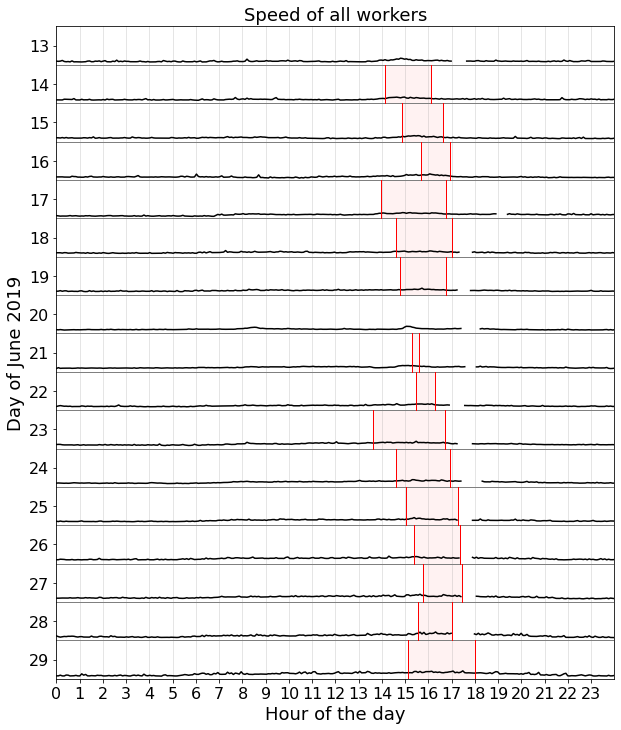

In [251]:

f,ax=plt.subplots(1,1,sharex=True,sharey=False)
f.set_size_inches(10*len(colnums),12)

tpx = np.linspace(0,24,numtimedivs)

# for k in range(len(colnums)):
k=0
a=ax
y_perday = np.array(toplotaveragevalues[k].copy())
# don't normalized like the weather data - set explicit values
#     minval, maxval = np.nanmin(y_perday), np.nanmax(y_perday)
#     title = titlelabel+' ('+str(np.round(minval,1))+' to '+str(np.round(maxval,1))+' '+units[k]+ ')'
#     y_perday = (y_perday-minval)/(maxval-minval)

yshift = [2.5,7][k] #1.05
yshifts=[]
for i,daynum in enumerate(daynumstoshow):
    offset=yshift*(len(daynumstoshow)-i-1)
    yshifts.append(offset)
#         if k==0:
    a.axhline(offset,linewidth=1,zorder=-1,alpha=1,c='grey')
    a.plot(tpx,y_perday[i]+offset,c='k')


[a.axvline(j,c='grey',linewidth=1,zorder=-1,alpha=0.2) for j in range(24)]    
a.set_xlim([0,24])
a.tick_params(labelsize=16)
a.set_xlim([0,24])
#ticks
a.set_xticks(np.arange(24))
a.set_xticklabels(np.arange(24))
a.set_yticks(np.array(yshifts)+yshift/2)
a.set_yticklabels(daynumstoshow+junedaynumoffset)
# title and labels
a.set_xlabel('Hour of the day',fontsize=18)
a.set_ylabel('Day of June 2019',fontsize=18)

yshifts = np.insert((yshifts),0,yshifts[0]+yshift)
a.set_ylim([yshifts[-1],yshifts[0]])
for i,act in enumerate(np.array(collectiveactivated)):
    ymax, ymin = (yshifts[i])/yshifts[0], (yshifts[i+1])/yshifts[0]
    act = act/(numtimedivs)*24*287/288  # looks reasonable, I didn't do the linspace the most exact way though
    if act[0]>0:
        a.axvline(act[0],c='r',ymin=ymin,ymax=ymax,linewidth=1)
        a.axvline(act[1]+2/12,c='r',ymin=ymin,ymax=ymax,linewidth=1)    
        a.axvspan(act[0],act[1]+2/12,color='r',alpha=0.05,zorder=-1,ymin=ymin,ymax=ymax)


ax.set_title('Speed of all workers',fontsize=18)            
# ax[1].set_title('Dispersion of workers on exit frame',fontsize=18)               

        
        
plt.subplots_adjust(wspace=0.15)
plt.savefig('image-output/workers-all-hourly.pdf')
plt.show()